<a href="https://colab.research.google.com/github/dissimo7/capstone_project/blob/main/2025_portfolio_allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Allocation

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from datetime import datetime, timedelta

def get_fx_rate(ticker):
    """Fetch the latest closing rate for the given ticker using yfinance."""
    data = yf.Ticker(ticker).history(period="1d")
    return data["Close"].iloc[-1]

def omega_ratio_ewma(returns_series, threshold=0.0, alpha=0.1587):
    """
    Computes an EWMA-weighted Omega ratio for a series of returns.
    """
    n = len(returns_series)
    weights = np.array([(1 - alpha)**(n - i - 1) for i in range(n)])
    weights /= weights.sum()

    sorted_idx = np.argsort(returns_series)
    sorted_returns = returns_series.iloc[sorted_idx].values
    sorted_weights = weights[sorted_idx]

    above = sorted_returns > threshold
    numerator = np.sum(sorted_weights[above] * (sorted_returns[above] - threshold))

    below = sorted_returns < threshold
    denominator = np.sum(sorted_weights[below] * (threshold - sorted_returns[below]))

    return numerator / denominator if denominator != 0 else np.inf

def get_last_friday(reference_date=None):
    """
    Returns the most recent Friday (or the last available weekday) relative to the given reference_date.
    """
    if reference_date is None:
        reference_date = datetime.today()
    offset = (reference_date.weekday() - 4) % 7
    return reference_date - timedelta(days=offset)

def main(tickers, total_capital=416784, window=30, price_date=None):
    """
    Parameters:
      tickers: List of ticker symbols.
      total_capital: Total capital to allocate (in COP).
      window: Rolling window size in days.
      price_date: (Optional) Date for which to use the closing prices.
                  If None, defaults to the most recent Friday.

    The function fetches stock price data and forex conversion rates automatically using yfinance.
    It then computes EWMA-based rolling Sharpe and Omega ratios and determines the allocation.
    """

    # ------------------------------------------------------------------------
    # 1) Download stock data (6 months of daily Close).
    # ------------------------------------------------------------------------
    df = yf.download(tickers, period="6mo", interval="1d", progress=False)
    if "Close" not in df.columns:
        print("No 'Close' data found from yfinance. Exiting.")
        return
    all_closes = df["Close"]
    all_closes.sort_index(inplace=True)

    # ------------------------------------------------------------------------
    # 1a) Determine the effective price_date.
    #     If no price_date is provided, use the last Friday.
    # ------------------------------------------------------------------------
    if price_date is None:
        price_date = get_last_friday()
    else:
        price_date = pd.to_datetime(price_date)

    # Since markets are closed on weekends/holidays, find the last available trading date <= price_date.
    available_dates = all_closes.index[all_closes.index <= price_date]
    if len(available_dates) == 0:
        print(f"No available price data on or before {price_date.date()}. Exiting.")
        return
    effective_date = available_dates[-1]
    print(f"Using stock closing prices from {effective_date.date()} for allocation calculations.")

    # ------------------------------------------------------------------------
    # 2) Automatically fetch the latest forex conversion rates via yfinance.
    #    - For Euro and GBP, we use direct tickers.
    #    - For Chilean Peso, we convert via USD (if no direct ticker available).
    # ------------------------------------------------------------------------
    try:
        eur_to_cop = get_fx_rate("EURCOP=X")
        gbp_to_cop = get_fx_rate("GBPCOP=X")
        usd_to_cop = get_fx_rate("USDCOP=X")
        usd_to_clp = get_fx_rate("USDCLP=X")
        # Calculate CLP to COP: first convert CLP to USD then USD to COP.
        clp_to_cop = (1 / usd_to_clp) * usd_to_cop
    except Exception as e:
        print("Error fetching forex data:", e)
        return

    # Build a conversion_rates dictionary based on ticker suffix.
    # Assumptions:
    #   - Tickers ending with .CL are already in COP.
    #   - .SN: Assume prices are in Chilean Peso (CLP).
    #   - .AS: Prices in Euro.
    #   - .L : Prices in British Pound.
    conversion_rates = {
        "CL": 1.0,         # Already in COP.
        "SN": clp_to_cop,    # Convert CLP to COP.
        "AS": eur_to_cop,    # Convert Euro to COP.
        "L": gbp_to_cop      # Convert GBP to COP.
    }

    # ------------------------------------------------------------------------
    # 3) Determine stock prices for allocation.
    #    For each ticker, fetch the closing price at effective_date and convert to COP.
    # ------------------------------------------------------------------------
    computed_prices = {}
    for ticker in tickers:
        try:
            raw_price = all_closes.loc[effective_date, ticker]
        except KeyError:
            print(f"Price for {ticker} not found on {effective_date.date()}, skipping.")
            continue
        suffix = ticker.split('.')[-1]
        conversion_rate = conversion_rates.get(suffix, 1.0)
        computed_prices[ticker] = raw_price * conversion_rate
    prices_for_allocation = computed_prices

    print("\nComputed Prices (in COP) based on effective_date and forex rates:")
    for t, price in prices_for_allocation.items():
        print(f"{t}: {price:,.2f}")

    # ------------------------------------------------------------------------
    # 4) Compute EWMA-based rolling Sharpe and Omega ratios.
    # ------------------------------------------------------------------------
    rolled_sharpe_dict = {}
    final_sharpe_dict = {}
    rolled_omega_dict = {}
    final_omega_dict = {}

    for ticker in tickers:
        series = all_closes[ticker].dropna()
        if len(series) < window:
            continue
        # Use the last 59 rows for calculations.
        series = series.tail(59)

        # ----- Sharpe Ratio Calculation -----
        log_returns = np.log(series / series.shift(1)).dropna()
        if log_returns.empty:
            continue

        ewma_mean = log_returns.ewm(alpha=0.1587, adjust=False).mean()
        ewma_std = log_returns.ewm(alpha=0.1587, adjust=False).std()
        ann_factor = 252
        ewma_sharpe = (ewma_mean / ewma_std) * np.sqrt(ann_factor)
        ewma_sharpe.replace([np.inf, -np.inf], np.nan, inplace=True)
        ewma_sharpe.dropna(inplace=True)
        if ewma_sharpe.empty:
            continue

        rolled_sharpe_dict[ticker] = ewma_sharpe
        final_sharpe_dict[ticker] = ewma_sharpe.iloc[-1]

        # ----- Omega Ratio Calculation -----
        log_returns = np.log(series / series.shift(1)).dropna()
        ewma_omega = log_returns.rolling(window=window).apply(
        lambda x: omega_ratio_ewma(pd.Series(x), threshold=0.0, alpha=0.1587),
        raw=False
        )
        ewma_omega.dropna(inplace=True)
        if ewma_omega.empty:
            continue
        rolled_omega_dict[ticker] = ewma_omega
        final_omega_dict[ticker] = ewma_omega.iloc[-1]

    if not rolled_sharpe_dict or not rolled_omega_dict:
        print("No valid EWMA-based metrics for any ticker. Exiting.")
        return

    # ------------------------------------------------------------------------
    # 5) Plot EWMA-based rolling Sharpe for the LAST 30 TRADING DAYS.
    # ------------------------------------------------------------------------
    '''
    sharpe_df = pd.DataFrame(rolled_sharpe_dict).sort_index()
    plot_sharpe_df = sharpe_df.tail(30)

    fig, ax = plt.subplots(figsize=(12, 6))
    for ticker in plot_sharpe_df.columns:
        ax.plot(plot_sharpe_df.index, plot_sharpe_df[ticker], label=ticker)
    ax.set_title("EWMA-based Rolling Sharpe Ratio (alpha=0.1587, last 30 trading days)")
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    for dateval in plot_sharpe_df.index:
        if dateval.weekday() == 4:  # Mark Fridays
            ax.axvline(dateval, color='gray', linestyle='--', alpha=0.5)
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------------
    # 6) Plot EWMA-based rolling Omega Ratio for the LAST 30 TRADING DAYS.
    # ------------------------------------------------------------------------
    omega_df = pd.DataFrame(rolled_omega_dict).sort_index()
    plot_omega_df = omega_df.tail(30)

    fig, ax = plt.subplots(figsize=(12, 6))
    for ticker in plot_omega_df.columns:
        ax.plot(plot_omega_df.index, plot_omega_df[ticker], label=ticker)
    ax.set_title("EWMA-weighted Rolling Omega Ratio (alpha=0.1587, last 30 trading days)")
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    for dateval in plot_omega_df.index:
        if dateval.weekday() == 4:
            ax.axvline(dateval, color='gray', linestyle='--', alpha=0.5)
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    '''

    # ------------------------------------------------------------------------
    # 7) Print final Sharpe and Omega ratios for each ticker.
    # ------------------------------------------------------------------------
    final_df = pd.DataFrame({
        "Sharpe": final_sharpe_dict,
        "Omega": final_omega_dict
    })
    final_df.dropna(inplace=True)
    print("\nLatest EWMA-based Metrics (each ticker computed individually):")
    print(final_df)

    # ------------------------------------------------------------------------
    # 8) Combine weights.
    # ------------------------------------------------------------------------
    # Compute z-scores for Sharpe and Omega ratios
    sharpe_z = (final_df["Sharpe"] - final_df["Sharpe"].mean()) / final_df["Sharpe"].std()
    omega_z  = (final_df["Omega"] - final_df["Omega"].mean()) / final_df["Omega"].std()

    # Shift z-scores to make them non-negative (if needed)
    sharpe_shift = sharpe_z - sharpe_z.min()
    omega_shift  = omega_z - omega_z.min()

    # Normalize the shifted scores to sum to one
    sharpe_norm = sharpe_shift / sharpe_shift.sum()
    omega_norm  = omega_shift / omega_shift.sum()

    naive_weight = 1.0 / len(final_df.index)
    w_sharpe = 0.6827
    w_omega = 0.2718
    w_naive = 0.0455

    combined_raw = (w_sharpe * sharpe_norm + w_omega * omega_norm + w_naive * naive_weight)
    combined_normalized = combined_raw / combined_raw.sum()
    final_df["CombinedWeight"] = combined_normalized


    print("\nNormalization and Combined Weights:")
    print(pd.DataFrame({
        "Sharpe": sharpe_norm,
        "Omega": omega_norm,
        "CombinedWeight": combined_normalized
    }))

    # ------------------------------------------------------------------------
    # 9) Calculate allocation of total_capital, shares, and cost.
    # ------------------------------------------------------------------------
    allocation_list = []
    shares_list = []
    cost_list = []

    for ticker in final_df.index:
        w = final_df.loc[ticker, "CombinedWeight"]
        allocation = w * total_capital
        price_per_share = prices_for_allocation.get(ticker, np.nan)
        if not np.isnan(price_per_share) and price_per_share > 0:
            sh = int(np.floor(allocation / price_per_share))
            cst = sh * price_per_share
        else:
            sh = 0
            cst = 0
        allocation_list.append(allocation)
        shares_list.append(sh)
        cost_list.append(cst)

    final_df["Allocation"] = allocation_list
    final_df["Shares"] = shares_list
    final_df["Cost"] = cost_list

    final_df.sort_values(by="CombinedWeight", ascending=False, inplace=True)

    total_cost = final_df["Cost"].sum()
    leftover = total_capital - total_cost

    print("\nFinal Weights & Allocation:")
    print(final_df)
    print(f"\nTotal capital = {total_capital:,.2f} COP")
    print(f"Total cost    = {total_cost:,.2f} COP")
    print(f"Leftover cash = {leftover:,.2f} COP")
    print("------------------------------------")

# ------------------------------------------------------------------------
    # 11) Categorize tickers and aggregate weights by category.
    # ------------------------------------------------------------------------
    category_map = {
        "PFAVAL.CL": "col",
        "GEB.CL": "col",
        "MINEROS.CL": "col",
        "TERPEL.CL": "col",
        "BVC.CL": "col",
        "PFCORFICOL.CL": "col",
        "PFDAVVNDA.CL": "col",
        "PFGRUPSURA.CL": "col",
        "PFBCOLOM.CL": "col",
        "GRUBOLIVAR.CL": "col",
        "ENELCHILE.SN": "chile",
        "RIPLEY.SN": "chile",
        "AGUAS-A.SN": "chile",
        "CONCHATORO.SN": "chile",
        "CENCOSUD.SN": "chile",
        "MALLPLAZA.SN": "chile",
        "ANDINA-B.SN": "chile",
        "QUINENCO.SN": "chile",
        "FALABELLA.SN": "chile",
        "CCU.SN": "chile",
        "ICOLCAP.CL": "etf",
        "CFMITNIPSA.SN": "etf",
        "ICHN.AS": "etf",
        "RBOT.L": "etf",
        "UIFS.L": "etf",
        "PEI.CL": "etf",
        "IUIT.L": "etf"
    }

    # Add category information to final_df
    final_df["Category"] = final_df.index.map(lambda t: category_map.get(t, "uncategorized"))

    # Aggregate the combined weights by category
    category_weights = final_df.groupby("Category")["CombinedWeight"].sum()
    print("\nAggregated Combined Weights by Category:")
    print(category_weights)

# =================== EXAMPLE USAGE ===================
if __name__ == "__main__":
    ticker_list = [

        "PFAVAL.CL",
        "GEB.CL",
        "MINEROS.CL",
        "TERPEL.CL",
        "BVC.CL",
        "PFCORFICOL.CL",
        "PFDAVVNDA.CL",
        "PFGRUPSURA.CL",
        "PFBCOLOM.CL",
        "GRUBOLIVAR.CL",
        "ENELCHILE.SN",
        "RIPLEY.SN",
        "AGUAS-A.SN",
        "CONCHATORO.SN",
        "CENCOSUD.SN",
        "MALLPLAZA.SN",
        "ANDINA-B.SN",
        "QUINENCO.SN",
        "FALABELLA.SN",
        "CCU.SN",
        "ICOLCAP.CL",
        "CFMITNIPSA.SN",
        "ICHN.AS",
        "RBOT.L",
        "UIFS.L",
        "PEI.CL",
        "IUIT.L"


    ]

    # Run the main function.
    # If you want to use a specific date (for example, "2025-03-07"), pass it as the price_date parameter.
    main(
        tickers=ticker_list,
        total_capital=600000,
        window=30,
        # Uncomment to use a manual price date:
        price_date="2025-03-14"
    )


Using stock closing prices from 2025-03-14 for allocation calculations.

Computed Prices (in COP) based on effective_date and forex rates:
PFAVAL.CL: 595.00
GEB.CL: 2,860.00
MINEROS.CL: 5,370.00
TERPEL.CL: 12,640.00
BVC.CL: 12,580.00
PFCORFICOL.CL: 17,280.00
PFDAVVNDA.CL: 20,600.00
PFGRUPSURA.CL: 37,400.00
PFBCOLOM.CL: 44,220.00
GRUBOLIVAR.CL: 74,840.00
ENELCHILE.SN: 273.43
RIPLEY.SN: 1,500.67
AGUAS-A.SN: 1,440.15
CONCHATORO.SN: 5,605.43
CENCOSUD.SN: 11,034.31
MALLPLAZA.SN: 8,562.63
ANDINA-B.SN: 15,139.08
QUINENCO.SN: 16,088.03
FALABELLA.SN: 16,970.77
CCU.SN: 30,189.88
ICOLCAP.CL: 15,988.00
CFMITNIPSA.SN: 16,423.03
ICHN.AS: 25,343.57
RBOT.L: 71,250.81
UIFS.L: 5,754,669.59
PEI.CL: 75,000.00
IUIT.L: 161,745.71

Latest EWMA-based Metrics (each ticker computed individually):
                  Sharpe     Omega
PFAVAL.CL      -0.197960  0.939403
GEB.CL          2.968575  1.668768
MINEROS.CL      0.854872  1.380134
TERPEL.CL       2.216430  1.583819
BVC.CL          2.540631  1.728674
PFCORFIC

Colombia


YF.download() has changed argument auto_adjust default to True
Using stock closing prices from 2025-03-12 for allocation calculations.

Computed Prices (in COP) based on effective_date and forex rates:
PFAVAL.CL: 600.00
GEB.CL: 2,850.00
MINEROS.CL: 5,380.00
TERPEL.CL: 12,540.00
BVC.CL: 12,600.00
PFCORFICOL.CL: 17,260.00
PFDAVVNDA.CL: 20,500.00
PFGRUPSURA.CL: 39,000.00
PFBCOLOM.CL: 43,460.00
GRUBOLIVAR.CL: 75,000.00


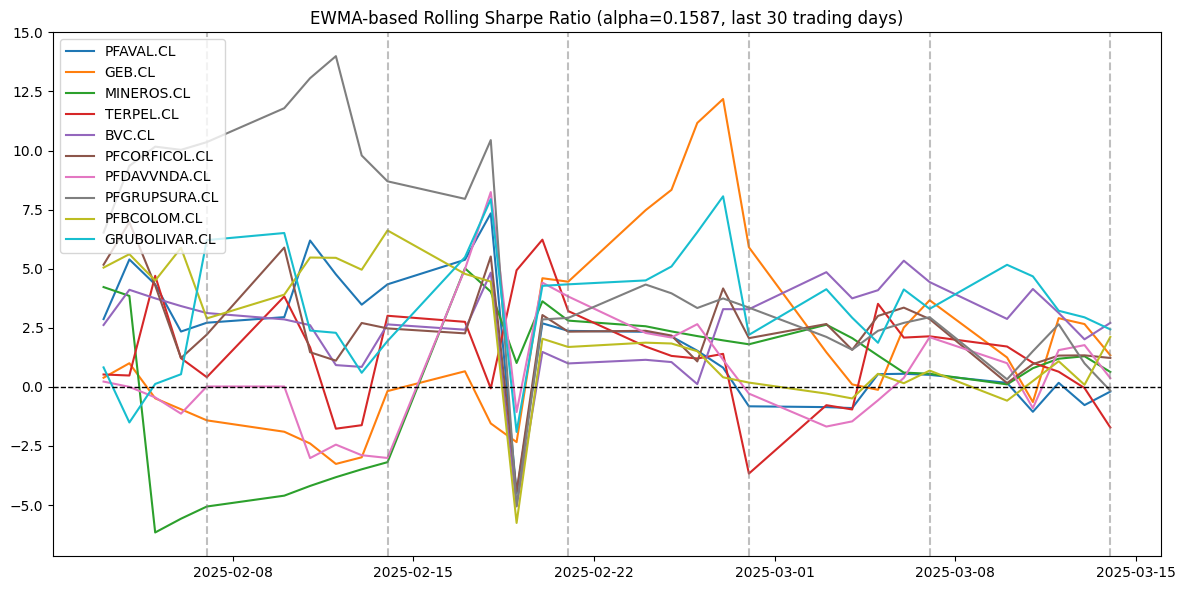

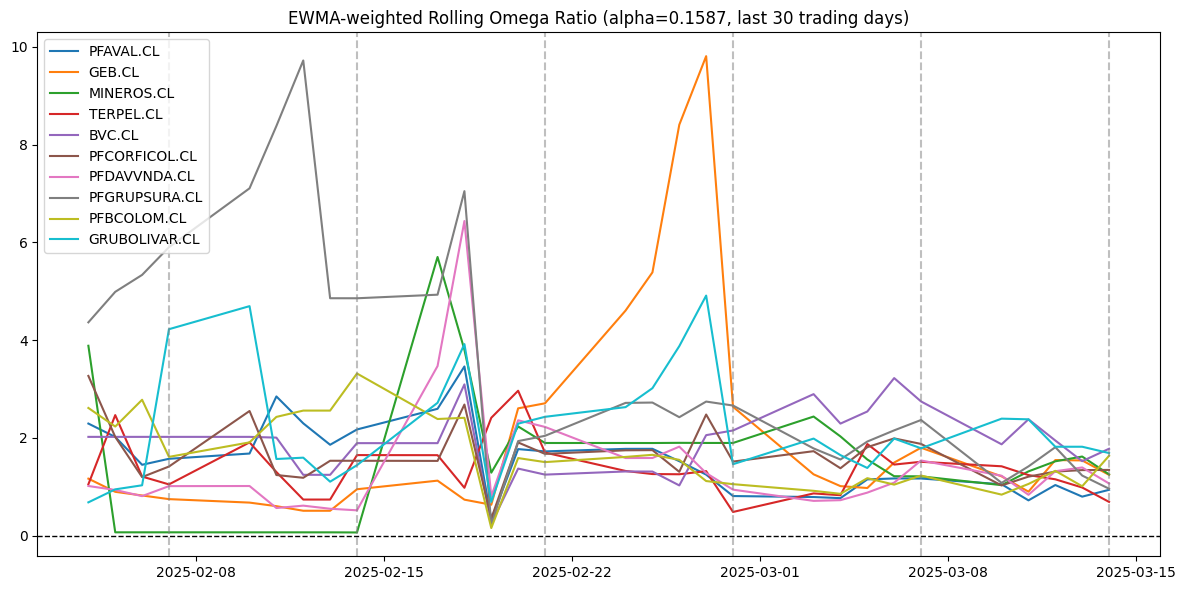


Latest EWMA-based Metrics (each ticker computed individually):
                 Sharpe     Omega
PFAVAL.CL     -0.197960  0.939403
GEB.CL         1.337478  1.245693
MINEROS.CL     0.631678  1.255554
TERPEL.CL     -1.718020  0.692264
BVC.CL         2.709396  1.779467
PFCORFICOL.CL  1.223573  1.346510
PFDAVVNDA.CL   0.369408  1.069109
PFGRUPSURA.CL -0.163440  0.961544
PFBCOLOM.CL    2.113183  1.635357
GRUBOLIVAR.CL  2.432684  1.691351

Normalization and Combined Weights:
                 Sharpe     Omega  CombinedWeight
PFAVAL.CL      0.058648  0.043406        0.056387
GEB.CL         0.117890  0.097202        0.111453
MINEROS.CL     0.090658  0.098934        0.093333
TERPEL.CL      0.000000  0.000000        0.004550
BVC.CL         0.170823  0.190951        0.173071
PFCORFICOL.CL  0.113495  0.114909        0.113265
PFDAVVNDA.CL   0.080539  0.066187        0.077524
PFGRUPSURA.CL  0.059980  0.047295        0.058353
PFBCOLOM.CL    0.147819  0.165641        0.150487
GRUBOLIVAR.CL  0.160146  

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from datetime import datetime, timedelta

def get_fx_rate(ticker):
    """Fetch the latest closing rate for the given ticker using yfinance."""
    data = yf.Ticker(ticker).history(period="1d")
    return data["Close"].iloc[-1]

def omega_ratio_ewma(returns_series, threshold=0.0, alpha=0.1587):
    """
    Computes an EWMA-weighted Omega ratio for a series of returns.
    """
    n = len(returns_series)
    weights = np.array([(1 - alpha)**(n - i - 1) for i in range(n)])
    weights /= weights.sum()

    sorted_idx = np.argsort(returns_series)
    sorted_returns = returns_series.iloc[sorted_idx].values
    sorted_weights = weights[sorted_idx]

    above = sorted_returns > threshold
    numerator = np.sum(sorted_weights[above] * (sorted_returns[above] - threshold))

    below = sorted_returns < threshold
    denominator = np.sum(sorted_weights[below] * (threshold - sorted_returns[below]))

    return numerator / denominator if denominator != 0 else np.inf

def get_last_friday(reference_date=None):
    """
    Returns the most recent Friday (or the last available weekday) relative to the given reference_date.
    """
    if reference_date is None:
        reference_date = datetime.today()
    offset = (reference_date.weekday() - 4) % 7
    return reference_date - timedelta(days=offset)

def main(tickers, total_capital=416784, window=30, price_date=None):
    """
    Parameters:
      tickers: List of ticker symbols.
      total_capital: Total capital to allocate (in COP).
      window: Rolling window size in days.
      price_date: (Optional) Date for which to use the closing prices.
                  If None, defaults to the most recent Friday.

    The function fetches stock price data and forex conversion rates automatically using yfinance.
    It then computes EWMA-based rolling Sharpe and Omega ratios and determines the allocation.
    """

    # ------------------------------------------------------------------------
    # 1) Download stock data (6 months of daily Close).
    # ------------------------------------------------------------------------
    df = yf.download(tickers, period="6mo", interval="1d", progress=False)
    if "Close" not in df.columns:
        print("No 'Close' data found from yfinance. Exiting.")
        return
    all_closes = df["Close"]
    all_closes.sort_index(inplace=True)

    # ------------------------------------------------------------------------
    # 1a) Determine the effective price_date.
    #     If no price_date is provided, use the last Friday.
    # ------------------------------------------------------------------------
    if price_date is None:
        price_date = get_last_friday()
    else:
        price_date = pd.to_datetime(price_date)

    # Since markets are closed on weekends/holidays, find the last available trading date <= price_date.
    available_dates = all_closes.index[all_closes.index <= price_date]
    if len(available_dates) == 0:
        print(f"No available price data on or before {price_date.date()}. Exiting.")
        return
    effective_date = available_dates[-1]
    print(f"Using stock closing prices from {effective_date.date()} for allocation calculations.")

    # ------------------------------------------------------------------------
    # 2) Automatically fetch the latest forex conversion rates via yfinance.
    #    - For Euro and GBP, we use direct tickers.
    #    - For Chilean Peso, we convert via USD (if no direct ticker available).
    # ------------------------------------------------------------------------
    try:
        eur_to_cop = get_fx_rate("EURCOP=X")
        gbp_to_cop = get_fx_rate("GBPCOP=X")
        usd_to_cop = get_fx_rate("USDCOP=X")
        usd_to_clp = get_fx_rate("USDCLP=X")
        # Calculate CLP to COP: first convert CLP to USD then USD to COP.
        clp_to_cop = (1 / usd_to_clp) * usd_to_cop
    except Exception as e:
        print("Error fetching forex data:", e)
        return

    # Build a conversion_rates dictionary based on ticker suffix.
    # Assumptions:
    #   - Tickers ending with .CL are already in COP.
    #   - .SN: Assume prices are in Chilean Peso (CLP).
    #   - .AS: Prices in Euro.
    #   - .L : Prices in British Pound.
    conversion_rates = {
        "CL": 1.0,         # Already in COP.
        "SN": clp_to_cop,    # Convert CLP to COP.
        "AS": eur_to_cop,    # Convert Euro to COP.
        "L": gbp_to_cop      # Convert GBP to COP.
    }

    # ------------------------------------------------------------------------
    # 3) Determine stock prices for allocation.
    #    For each ticker, fetch the closing price at effective_date and convert to COP.
    # ------------------------------------------------------------------------
    computed_prices = {}
    for ticker in tickers:
        try:
            raw_price = all_closes.loc[effective_date, ticker]
        except KeyError:
            print(f"Price for {ticker} not found on {effective_date.date()}, skipping.")
            continue
        suffix = ticker.split('.')[-1]
        conversion_rate = conversion_rates.get(suffix, 1.0)
        computed_prices[ticker] = raw_price * conversion_rate
    prices_for_allocation = computed_prices

    print("\nComputed Prices (in COP) based on effective_date and forex rates:")
    for t, price in prices_for_allocation.items():
        print(f"{t}: {price:,.2f}")

    # ------------------------------------------------------------------------
    # 4) Compute EWMA-based rolling Sharpe and Omega ratios.
    # ------------------------------------------------------------------------
    rolled_sharpe_dict = {}
    final_sharpe_dict = {}
    rolled_omega_dict = {}
    final_omega_dict = {}

    for ticker in tickers:
        series = all_closes[ticker].dropna()
        if len(series) < window:
            continue
        # Use the last 59 rows for calculations.
        series = series.tail(59)

        # ----- Sharpe Ratio Calculation -----
        log_returns = np.log(series / series.shift(1)).dropna()
        if log_returns.empty:
            continue

        ewma_mean = log_returns.ewm(alpha=0.1587, adjust=False).mean()
        ewma_std = log_returns.ewm(alpha=0.1587, adjust=False).std()
        ann_factor = 252
        ewma_sharpe = (ewma_mean / ewma_std) * np.sqrt(ann_factor)
        ewma_sharpe.replace([np.inf, -np.inf], np.nan, inplace=True)
        ewma_sharpe.dropna(inplace=True)
        if ewma_sharpe.empty:
            continue

        rolled_sharpe_dict[ticker] = ewma_sharpe
        final_sharpe_dict[ticker] = ewma_sharpe.iloc[-1]

        # ----- Omega Ratio Calculation -----
        log_returns = np.log(series / series.shift(1)).dropna()
        ewma_omega = log_returns.rolling(window=window).apply(
        lambda x: omega_ratio_ewma(pd.Series(x), threshold=0.0, alpha=0.1587),
        raw=False
        )
        ewma_omega.dropna(inplace=True)
        if ewma_omega.empty:
            continue
        rolled_omega_dict[ticker] = ewma_omega
        final_omega_dict[ticker] = ewma_omega.iloc[-1]

    if not rolled_sharpe_dict or not rolled_omega_dict:
        print("No valid EWMA-based metrics for any ticker. Exiting.")
        return

    # ------------------------------------------------------------------------
    # 5) Plot EWMA-based rolling Sharpe for the LAST 30 TRADING DAYS.
    # ------------------------------------------------------------------------
    sharpe_df = pd.DataFrame(rolled_sharpe_dict).sort_index()
    plot_sharpe_df = sharpe_df.tail(30)

    fig, ax = plt.subplots(figsize=(12, 6))
    for ticker in plot_sharpe_df.columns:
        ax.plot(plot_sharpe_df.index, plot_sharpe_df[ticker], label=ticker)
    ax.set_title("EWMA-based Rolling Sharpe Ratio (alpha=0.1587, last 30 trading days)")
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    for dateval in plot_sharpe_df.index:
        if dateval.weekday() == 4:  # Mark Fridays
            ax.axvline(dateval, color='gray', linestyle='--', alpha=0.5)
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------------
    # 6) Plot EWMA-based rolling Omega Ratio for the LAST 30 TRADING DAYS.
    # ------------------------------------------------------------------------
    omega_df = pd.DataFrame(rolled_omega_dict).sort_index()
    plot_omega_df = omega_df.tail(30)

    fig, ax = plt.subplots(figsize=(12, 6))
    for ticker in plot_omega_df.columns:
        ax.plot(plot_omega_df.index, plot_omega_df[ticker], label=ticker)
    ax.set_title("EWMA-weighted Rolling Omega Ratio (alpha=0.1587, last 30 trading days)")
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    for dateval in plot_omega_df.index:
        if dateval.weekday() == 4:
            ax.axvline(dateval, color='gray', linestyle='--', alpha=0.5)
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------------
    # 7) Print final Sharpe and Omega ratios for each ticker.
    # ------------------------------------------------------------------------
    final_df = pd.DataFrame({
        "Sharpe": final_sharpe_dict,
        "Omega": final_omega_dict
    })
    final_df.dropna(inplace=True)
    print("\nLatest EWMA-based Metrics (each ticker computed individually):")
    print(final_df)

    # ------------------------------------------------------------------------
    # 8) Combine weights.
    # ------------------------------------------------------------------------
    # Compute z-scores for Sharpe and Omega ratios
    sharpe_z = (final_df["Sharpe"] - final_df["Sharpe"].mean()) / final_df["Sharpe"].std()
    omega_z  = (final_df["Omega"] - final_df["Omega"].mean()) / final_df["Omega"].std()

    # Shift z-scores to make them non-negative (if needed)
    sharpe_shift = sharpe_z - sharpe_z.min()
    omega_shift  = omega_z - omega_z.min()

    # Normalize the shifted scores to sum to one
    sharpe_norm = sharpe_shift / sharpe_shift.sum()
    omega_norm  = omega_shift / omega_shift.sum()

    naive_weight = 1.0 / len(final_df.index)
    w_sharpe = 0.6827
    w_omega = 0.2718
    w_naive = 0.0455

    combined_raw = (w_sharpe * sharpe_norm + w_omega * omega_norm + w_naive * naive_weight)
    combined_normalized = combined_raw / combined_raw.sum()
    final_df["CombinedWeight"] = combined_normalized


    print("\nNormalization and Combined Weights:")
    print(pd.DataFrame({
        "Sharpe": sharpe_norm,
        "Omega": omega_norm,
        "CombinedWeight": combined_normalized
    }))

    # ------------------------------------------------------------------------
    # 9) Calculate allocation of total_capital, shares, and cost.
    # ------------------------------------------------------------------------
    allocation_list = []
    shares_list = []
    cost_list = []

    for ticker in final_df.index:
        w = final_df.loc[ticker, "CombinedWeight"]
        allocation = w * total_capital
        price_per_share = prices_for_allocation.get(ticker, np.nan)
        if not np.isnan(price_per_share) and price_per_share > 0:
            sh = int(np.floor(allocation / price_per_share))
            cst = sh * price_per_share
        else:
            sh = 0
            cst = 0
        allocation_list.append(allocation)
        shares_list.append(sh)
        cost_list.append(cst)

    final_df["Allocation"] = allocation_list
    final_df["Shares"] = shares_list
    final_df["Cost"] = cost_list

    final_df.sort_values(by="CombinedWeight", ascending=False, inplace=True)

    total_cost = final_df["Cost"].sum()
    leftover = total_capital - total_cost

    print("\nFinal Weights & Allocation:")
    print(final_df)
    print(f"\nTotal capital = {total_capital:,.2f} COP")
    print(f"Total cost    = {total_cost:,.2f} COP")
    print(f"Leftover cash = {leftover:,.2f} COP")
    print("------------------------------------")

# =================== EXAMPLE USAGE ===================
if __name__ == "__main__":
    ticker_list = [
        "PFAVAL.CL",
        "GEB.CL",
        "MINEROS.CL",
        "TERPEL.CL",
        "BVC.CL",
        #"ICOLCAP.CL",
        "PFCORFICOL.CL",
        #"HCOLSEL.CL",
        "PFDAVVNDA.CL",
        "PFGRUPSURA.CL",
        "PFBCOLOM.CL",
        "GRUBOLIVAR.CL"

    ]

    # Run the main function.
    # If you want to use a specific date (for example, "2025-03-07"), pass it as the price_date parameter.
    main(
        tickers=ticker_list,
        total_capital=405875,
        window=30,
        # Uncomment to use a manual price date:
        price_date="2025-03-14"
    )


Chile

Using stock closing prices from 2025-03-14 for allocation calculations.

Computed Prices (in COP) based on effective_date and forex rates:
ENELCHILE.SN: 273.43
RIPLEY.SN: 1,500.67
AGUAS-A.SN: 1,440.15
CONCHATORO.SN: 5,605.43
CENCOSUD.SN: 11,034.31
MALLPLAZA.SN: 8,562.63
ANDINA-B.SN: 15,139.08
QUINENCO.SN: 16,088.03
FALABELLA.SN: 16,970.77
CCU.SN: 30,189.88


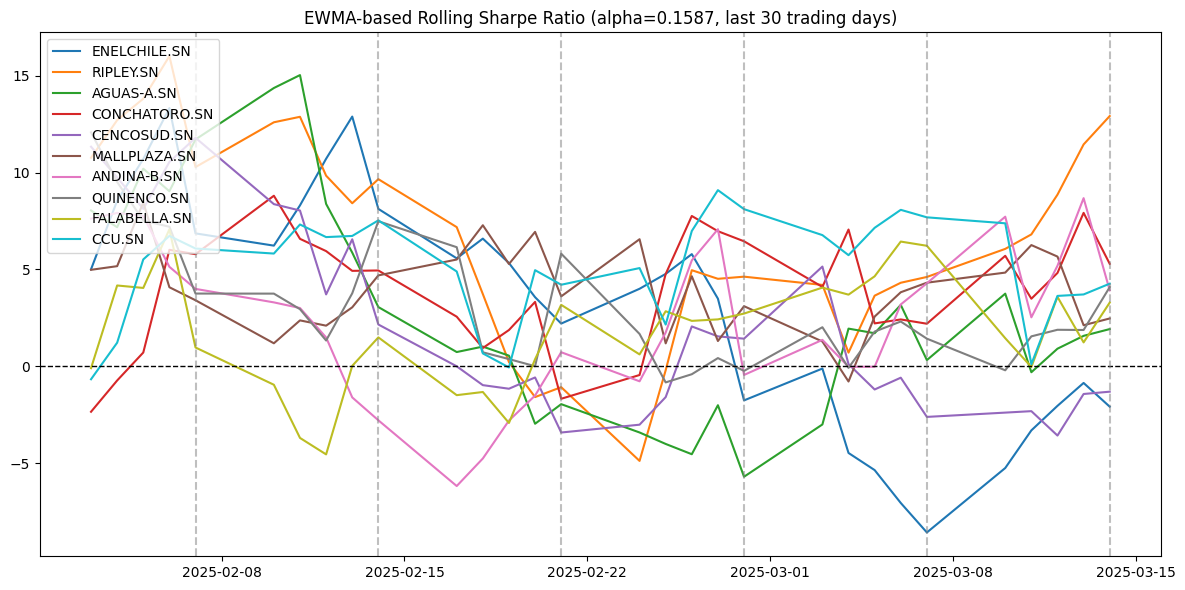

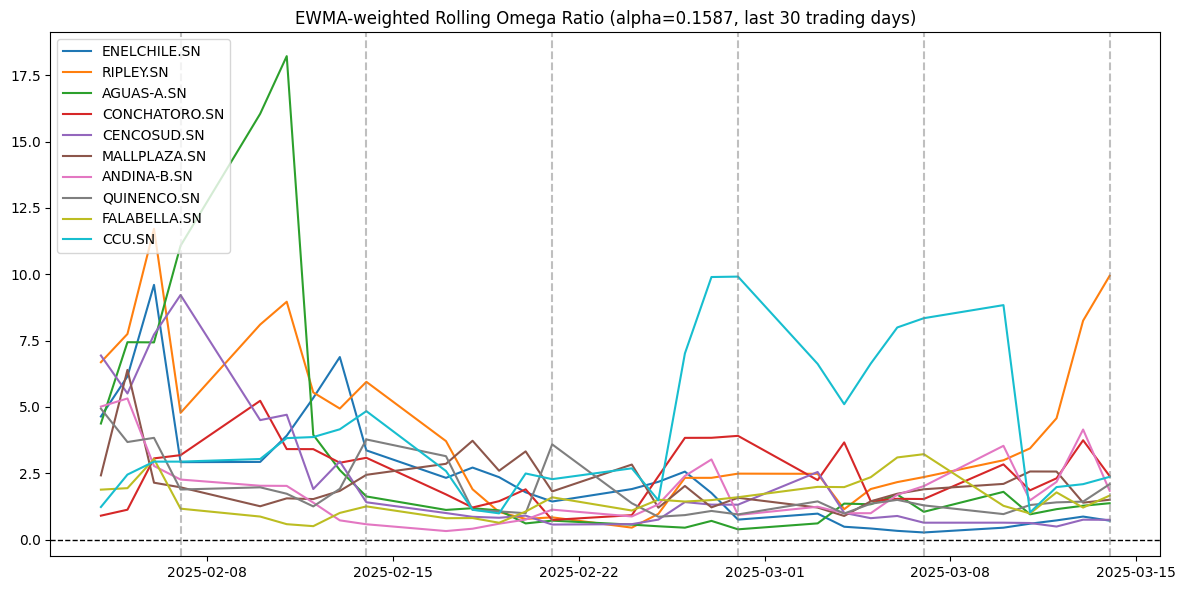


Latest EWMA-based Metrics (each ticker computed individually):
                  Sharpe     Omega
ENELCHILE.SN   -2.082633  0.714102
RIPLEY.SN      12.921569  9.944921
AGUAS-A.SN      1.923633  1.370751
CONCHATORO.SN   5.292127  2.393417
CENCOSUD.SN    -1.308379  0.745094
MALLPLAZA.SN    2.471533  1.502139
ANDINA-B.SN     3.921141  1.838859
QUINENCO.SN     4.090601  2.089532
FALABELLA.SN    3.290931  1.659061
CCU.SN          4.267832  2.366290

Normalization and Combined Weights:
                 Sharpe     Omega  CombinedWeight
ENELCHILE.SN   0.000000  0.000000        0.004550
RIPLEY.SN      0.269788  0.527984        0.332241
AGUAS-A.SN     0.072036  0.037559        0.063938
CONCHATORO.SN  0.132605  0.096053        0.121186
CENCOSUD.SN    0.013922  0.001773        0.014536
MALLPLAZA.SN   0.081888  0.045074        0.072706
ANDINA-B.SN    0.107953  0.064334        0.095735
QUINENCO.SN    0.111000  0.078672        0.101713
FALABELLA.SN   0.096621  0.054050        0.085204
CCU.SN        

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from datetime import datetime, timedelta

def get_fx_rate(ticker):
    """Fetch the latest closing rate for the given ticker using yfinance."""
    data = yf.Ticker(ticker).history(period="1d")
    return data["Close"].iloc[-1]

def omega_ratio_ewma(returns_series, threshold=0.0, alpha=0.1587):
    """
    Computes an EWMA-weighted Omega ratio for a series of returns.
    """
    n = len(returns_series)
    weights = np.array([(1 - alpha)**(n - i - 1) for i in range(n)])
    weights /= weights.sum()

    sorted_idx = np.argsort(returns_series)
    sorted_returns = returns_series.iloc[sorted_idx].values
    sorted_weights = weights[sorted_idx]

    above = sorted_returns > threshold
    numerator = np.sum(sorted_weights[above] * (sorted_returns[above] - threshold))

    below = sorted_returns < threshold
    denominator = np.sum(sorted_weights[below] * (threshold - sorted_returns[below]))

    return numerator / denominator if denominator != 0 else np.inf

def get_last_friday(reference_date=None):
    """
    Returns the most recent Friday (or the last available weekday) relative to the given reference_date.
    """
    if reference_date is None:
        reference_date = datetime.today()
    offset = (reference_date.weekday() - 4) % 7
    return reference_date - timedelta(days=offset)

def main(tickers, total_capital=416784, window=30, price_date=None):
    """
    Parameters:
      tickers: List of ticker symbols.
      total_capital: Total capital to allocate (in COP).
      window: Rolling window size in days.
      price_date: (Optional) Date for which to use the closing prices.
                  If None, defaults to the most recent Friday.

    The function fetches stock price data and forex conversion rates automatically using yfinance.
    It then computes EWMA-based rolling Sharpe and Omega ratios and determines the allocation.
    """

    # ------------------------------------------------------------------------
    # 1) Download stock data (6 months of daily Close).
    # ------------------------------------------------------------------------
    df = yf.download(tickers, period="6mo", interval="1d", progress=False)
    if "Close" not in df.columns:
        print("No 'Close' data found from yfinance. Exiting.")
        return
    all_closes = df["Close"]
    all_closes.sort_index(inplace=True)

    # ------------------------------------------------------------------------
    # 1a) Determine the effective price_date.
    #     If no price_date is provided, use the last Friday.
    # ------------------------------------------------------------------------
    if price_date is None:
        price_date = get_last_friday()
    else:
        price_date = pd.to_datetime(price_date)

    # Since markets are closed on weekends/holidays, find the last available trading date <= price_date.
    available_dates = all_closes.index[all_closes.index <= price_date]
    if len(available_dates) == 0:
        print(f"No available price data on or before {price_date.date()}. Exiting.")
        return
    effective_date = available_dates[-1]
    print(f"Using stock closing prices from {effective_date.date()} for allocation calculations.")

    # ------------------------------------------------------------------------
    # 2) Automatically fetch the latest forex conversion rates via yfinance.
    #    - For Euro and GBP, we use direct tickers.
    #    - For Chilean Peso, we convert via USD (if no direct ticker available).
    # ------------------------------------------------------------------------
    try:
        eur_to_cop = get_fx_rate("EURCOP=X")
        gbp_to_cop = get_fx_rate("GBPCOP=X")
        usd_to_cop = get_fx_rate("USDCOP=X")
        usd_to_clp = get_fx_rate("USDCLP=X")
        # Calculate CLP to COP: first convert CLP to USD then USD to COP.
        clp_to_cop = (1 / usd_to_clp) * usd_to_cop
    except Exception as e:
        print("Error fetching forex data:", e)
        return

    # Build a conversion_rates dictionary based on ticker suffix.
    # Assumptions:
    #   - Tickers ending with .CL are already in COP.
    #   - .SN: Assume prices are in Chilean Peso (CLP).
    #   - .AS: Prices in Euro.
    #   - .L : Prices in British Pound.
    conversion_rates = {
        "CL": 1.0,         # Already in COP.
        "SN": clp_to_cop,    # Convert CLP to COP.
        "AS": eur_to_cop,    # Convert Euro to COP.
        "L": gbp_to_cop      # Convert GBP to COP.
    }

    # ------------------------------------------------------------------------
    # 3) Determine stock prices for allocation.
    #    For each ticker, fetch the closing price at effective_date and convert to COP.
    # ------------------------------------------------------------------------
    computed_prices = {}
    for ticker in tickers:
        try:
            raw_price = all_closes.loc[effective_date, ticker]
        except KeyError:
            print(f"Price for {ticker} not found on {effective_date.date()}, skipping.")
            continue
        suffix = ticker.split('.')[-1]
        conversion_rate = conversion_rates.get(suffix, 1.0)
        computed_prices[ticker] = raw_price * conversion_rate
    prices_for_allocation = computed_prices

    print("\nComputed Prices (in COP) based on effective_date and forex rates:")
    for t, price in prices_for_allocation.items():
        print(f"{t}: {price:,.2f}")

    # ------------------------------------------------------------------------
    # 4) Compute EWMA-based rolling Sharpe and Omega ratios.
    # ------------------------------------------------------------------------
    rolled_sharpe_dict = {}
    final_sharpe_dict = {}
    rolled_omega_dict = {}
    final_omega_dict = {}

    for ticker in tickers:
        series = all_closes[ticker].dropna()
        if len(series) < window:
            continue
        # Use the last 59 rows for calculations.
        series = series.tail(59)

        # ----- Sharpe Ratio Calculation -----
        log_returns = np.log(series / series.shift(1)).dropna()
        if log_returns.empty:
            continue

        ewma_mean = log_returns.ewm(alpha=0.1587, adjust=False).mean()
        ewma_std = log_returns.ewm(alpha=0.1587, adjust=False).std()
        ann_factor = 252
        ewma_sharpe = (ewma_mean / ewma_std) * np.sqrt(ann_factor)
        ewma_sharpe.replace([np.inf, -np.inf], np.nan, inplace=True)
        ewma_sharpe.dropna(inplace=True)
        if ewma_sharpe.empty:
            continue

        rolled_sharpe_dict[ticker] = ewma_sharpe
        final_sharpe_dict[ticker] = ewma_sharpe.iloc[-1]

        # ----- Omega Ratio Calculation -----
        log_returns = np.log(series / series.shift(1)).dropna()
        ewma_omega = log_returns.rolling(window=window).apply(
        lambda x: omega_ratio_ewma(pd.Series(x), threshold=0.0, alpha=0.1587),
        raw=False
        )
        ewma_omega.dropna(inplace=True)
        if ewma_omega.empty:
            continue
        rolled_omega_dict[ticker] = ewma_omega
        final_omega_dict[ticker] = ewma_omega.iloc[-1]

    if not rolled_sharpe_dict or not rolled_omega_dict:
        print("No valid EWMA-based metrics for any ticker. Exiting.")
        return

    # ------------------------------------------------------------------------
    # 5) Plot EWMA-based rolling Sharpe for the LAST 30 TRADING DAYS.
    # ------------------------------------------------------------------------
    sharpe_df = pd.DataFrame(rolled_sharpe_dict).sort_index()
    plot_sharpe_df = sharpe_df.tail(30)

    fig, ax = plt.subplots(figsize=(12, 6))
    for ticker in plot_sharpe_df.columns:
        ax.plot(plot_sharpe_df.index, plot_sharpe_df[ticker], label=ticker)
    ax.set_title("EWMA-based Rolling Sharpe Ratio (alpha=0.1587, last 30 trading days)")
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    for dateval in plot_sharpe_df.index:
        if dateval.weekday() == 4:  # Mark Fridays
            ax.axvline(dateval, color='gray', linestyle='--', alpha=0.5)
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------------
    # 6) Plot EWMA-based rolling Omega Ratio for the LAST 30 TRADING DAYS.
    # ------------------------------------------------------------------------
    omega_df = pd.DataFrame(rolled_omega_dict).sort_index()
    plot_omega_df = omega_df.tail(30)

    fig, ax = plt.subplots(figsize=(12, 6))
    for ticker in plot_omega_df.columns:
        ax.plot(plot_omega_df.index, plot_omega_df[ticker], label=ticker)
    ax.set_title("EWMA-weighted Rolling Omega Ratio (alpha=0.1587, last 30 trading days)")
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    for dateval in plot_omega_df.index:
        if dateval.weekday() == 4:
            ax.axvline(dateval, color='gray', linestyle='--', alpha=0.5)
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------------
    # 7) Print final Sharpe and Omega ratios for each ticker.
    # ------------------------------------------------------------------------
    final_df = pd.DataFrame({
        "Sharpe": final_sharpe_dict,
        "Omega": final_omega_dict
    })
    final_df.dropna(inplace=True)
    print("\nLatest EWMA-based Metrics (each ticker computed individually):")
    print(final_df)

    # ------------------------------------------------------------------------
    # 8) Combine weights.
    # ------------------------------------------------------------------------
    # Compute z-scores for Sharpe and Omega ratios
    sharpe_z = (final_df["Sharpe"] - final_df["Sharpe"].mean()) / final_df["Sharpe"].std()
    omega_z  = (final_df["Omega"] - final_df["Omega"].mean()) / final_df["Omega"].std()

    # Shift z-scores to make them non-negative (if needed)
    sharpe_shift = sharpe_z - sharpe_z.min()
    omega_shift  = omega_z - omega_z.min()

    # Normalize the shifted scores to sum to one
    sharpe_norm = sharpe_shift / sharpe_shift.sum()
    omega_norm  = omega_shift / omega_shift.sum()

    naive_weight = 1.0 / len(final_df.index)
    w_sharpe = 0.6827
    w_omega = 0.2718
    w_naive = 0.0455

    combined_raw = (w_sharpe * sharpe_norm + w_omega * omega_norm + w_naive * naive_weight)
    combined_normalized = combined_raw / combined_raw.sum()
    final_df["CombinedWeight"] = combined_normalized


    print("\nNormalization and Combined Weights:")
    print(pd.DataFrame({
        "Sharpe": sharpe_norm,
        "Omega": omega_norm,
        "CombinedWeight": combined_normalized
    }))

    # ------------------------------------------------------------------------
    # 9) Calculate allocation of total_capital, shares, and cost.
    # ------------------------------------------------------------------------
    allocation_list = []
    shares_list = []
    cost_list = []

    for ticker in final_df.index:
        w = final_df.loc[ticker, "CombinedWeight"]
        allocation = w * total_capital
        price_per_share = prices_for_allocation.get(ticker, np.nan)
        if not np.isnan(price_per_share) and price_per_share > 0:
            sh = int(np.floor(allocation / price_per_share))
            cst = sh * price_per_share
        else:
            sh = 0
            cst = 0
        allocation_list.append(allocation)
        shares_list.append(sh)
        cost_list.append(cst)

    final_df["Allocation"] = allocation_list
    final_df["Shares"] = shares_list
    final_df["Cost"] = cost_list

    final_df.sort_values(by="CombinedWeight", ascending=False, inplace=True)

    total_cost = final_df["Cost"].sum()
    leftover = total_capital - total_cost

    print("\nFinal Weights & Allocation:")
    print(final_df)
    print(f"\nTotal capital = {total_capital:,.2f} COP")
    print(f"Total cost    = {total_cost:,.2f} COP")
    print(f"Leftover cash = {leftover:,.2f} COP")
    print("------------------------------------")

# =================== EXAMPLE USAGE ===================
if __name__ == "__main__":
    ticker_list = [
        #"LTM.SN",
        "ENELCHILE.SN",
        "RIPLEY.SN",
        "AGUAS-A.SN",
        "CONCHATORO.SN",
        "CENCOSUD.SN",
        "MALLPLAZA.SN",
        "ANDINA-B.SN",
        "QUINENCO.SN",
        "FALABELLA.SN",
        "CCU.SN"

    ]

    # Run the main function.
    # If you want to use a specific date (for example, "2025-03-07"), pass it as the price_date parameter.
    main(
        tickers=ticker_list,
        total_capital=405875,
        window=30,
        # Uncomment to use a manual price date:
        price_date="2025-03-14"
    )


ETFs

YF.download() has changed argument auto_adjust default to True
Using stock closing prices from 2025-03-21 for allocation calculations.

Computed Prices (in COP) based on effective_date and forex rates:
ICOLCAP.CL: 16,050.50
CFMITNIPSA.SN: 16,786.01
ICHN.AS: 22,934.90
RBOT.L: 55,433.40
IUFS.L: 59,292.69
EIMI.L: 147,437.17
IUIT.L: 125,684.82
SUAS.L: 63,007.51


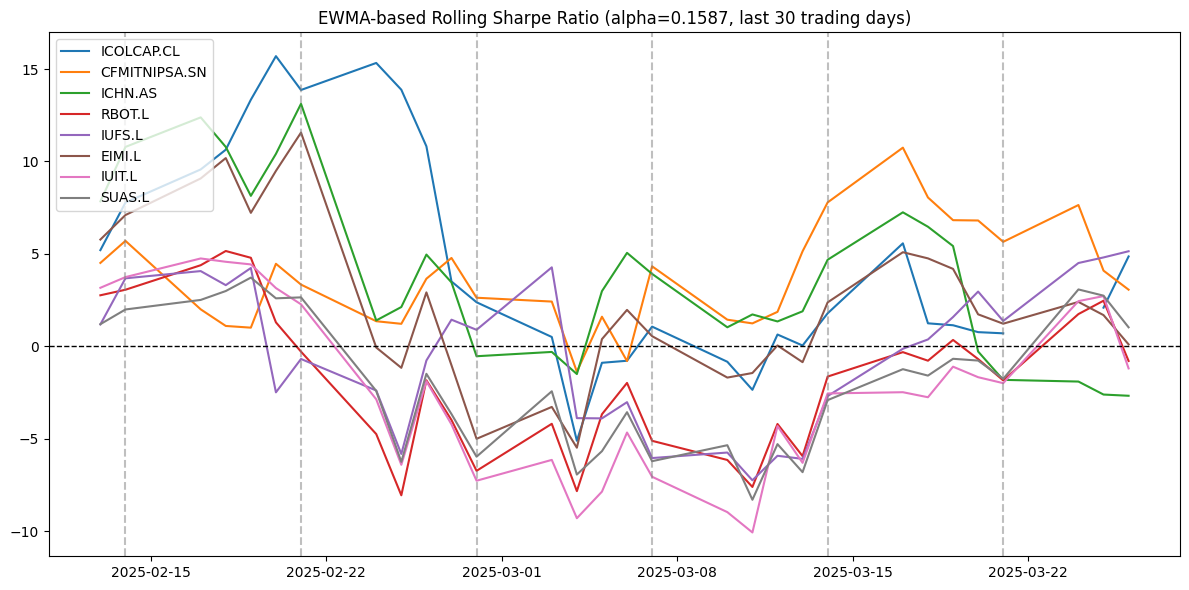

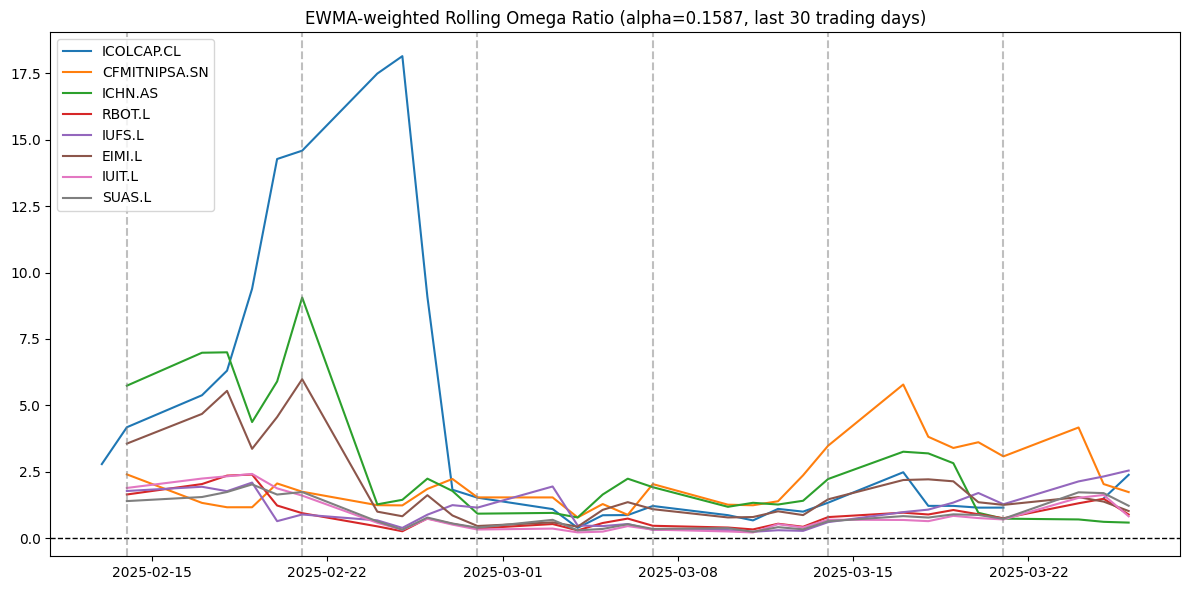


Latest EWMA-based Metrics (each ticker computed individually):
                 Sharpe     Omega
ICOLCAP.CL     4.866500  2.380870
CFMITNIPSA.SN  3.069202  1.730499
ICHN.AS       -2.666113  0.582165
RBOT.L        -0.783935  0.886828
IUFS.L         5.147830  2.542338
EIMI.L         0.112981  1.017715
IUIT.L        -1.186318  0.818809
SUAS.L         1.034982  1.215307

Normalization and Combined Weights:
                 Sharpe     Omega  CombinedWeight
ICOLCAP.CL     0.243584  0.275993        0.246998
CFMITNIPSA.SN  0.185465  0.176200        0.180195
ICHN.AS        0.000000  0.000000        0.005687
RBOT.L         0.060865  0.046748        0.059946
IUFS.L         0.252682  0.300769        0.259942
EIMI.L         0.089868  0.066831        0.085205
IUIT.L         0.047853  0.036311        0.048226
SUAS.L         0.119683  0.097149        0.113801

Final Weights & Allocation:
                 Sharpe     Omega  CombinedWeight     Allocation  Shares  \
IUFS.L         5.147830  2.542338     

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from datetime import datetime, timedelta

def get_fx_rate(ticker):
    """Fetch the latest closing rate for the given ticker using yfinance."""
    data = yf.Ticker(ticker).history(period="1d")
    return data["Close"].iloc[-1]

def omega_ratio_ewma(returns_series, threshold=0.0, alpha=0.1587):
    """
    Computes an EWMA-weighted Omega ratio for a series of returns.
    """
    n = len(returns_series)
    weights = np.array([(1 - alpha)**(n - i - 1) for i in range(n)])
    weights /= weights.sum()

    sorted_idx = np.argsort(returns_series)
    sorted_returns = returns_series.iloc[sorted_idx].values
    sorted_weights = weights[sorted_idx]

    above = sorted_returns > threshold
    numerator = np.sum(sorted_weights[above] * (sorted_returns[above] - threshold))

    below = sorted_returns < threshold
    denominator = np.sum(sorted_weights[below] * (threshold - sorted_returns[below]))

    return numerator / denominator if denominator != 0 else np.inf

def get_last_friday(reference_date=None):
    """
    Returns the most recent Friday (or the last available weekday) relative to the given reference_date.
    """
    if reference_date is None:
        reference_date = datetime.today()
    offset = (reference_date.weekday() - 4) % 7
    return reference_date - timedelta(days=offset)

def main(tickers, total_capital=416784, window=30, price_date=None):
    """
    Parameters:
      tickers: List of ticker symbols.
      total_capital: Total capital to allocate (in COP).
      window: Rolling window size in days.
      price_date: (Optional) Date for which to use the closing prices.
                  If None, defaults to the most recent Friday.

    The function fetches stock price data and forex conversion rates automatically using yfinance.
    It then computes EWMA-based rolling Sharpe and Omega ratios and determines the allocation.
    """

    # ------------------------------------------------------------------------
    # 1) Download stock data (6 months of daily Close).
    # ------------------------------------------------------------------------
    df = yf.download(tickers, period="6mo", interval="1d", progress=False)
    if "Close" not in df.columns:
        print("No 'Close' data found from yfinance. Exiting.")
        return
    all_closes = df["Close"]
    all_closes.sort_index(inplace=True)

    # ------------------------------------------------------------------------
    # 1a) Determine the effective price_date.
    #     If no price_date is provided, use the last Friday.
    # ------------------------------------------------------------------------
    if price_date is None:
        price_date = get_last_friday()
    else:
        price_date = pd.to_datetime(price_date)

    # Since markets are closed on weekends/holidays, find the last available trading date <= price_date.
    available_dates = all_closes.index[all_closes.index <= price_date]
    if len(available_dates) == 0:
        print(f"No available price data on or before {price_date.date()}. Exiting.")
        return
    effective_date = available_dates[-1]
    print(f"Using stock closing prices from {effective_date.date()} for allocation calculations.")

    # ------------------------------------------------------------------------
    # 2) Automatically fetch the latest forex conversion rates via yfinance.
    #    - For Euro and GBP, we use direct tickers.
    #    - For Chilean Peso, we convert via USD (if no direct ticker available).
    # ------------------------------------------------------------------------
    try:
        #eur_to_cop = get_fx_rate("EURCOP=X")
        #gbp_to_cop = get_fx_rate("GBPCOP=X")
        usd_to_cop = get_fx_rate("USDCOP=X")
        usd_to_clp = get_fx_rate("USDCLP=X")
        #usd_to_gbp = get_fx_rate("USDGBP=X")
        # Calculate CLP to COP: first convert CLP to USD then USD to COP.
        clp_to_cop = (1 / usd_to_clp) * usd_to_cop
        # Calculate GBP to COP: first convert GBP to USD then USD to COP
        #gbp_to_cop = (1 / usd_to_gbp) * usd_to_cop
    except Exception as e:
        print("Error fetching forex data:", e)
        return

    # Build a conversion_rates dictionary based on ticker suffix.
    # Assumptions:
    #   - Tickers ending with .CL are already in COP.
    #   - .SN: Assume prices are in Chilean Peso (CLP).
    #   - .AS: Prices in Euro.
    #   - .L : Prices in British Pound.
    conversion_rates = {
        "CL": 1.0,         # Already in COP.
        "SN": clp_to_cop,    # Convert CLP to COP.
        "AS": usd_to_cop,    # Convert Euro to COP.
        "L": usd_to_cop      # Convert GBP to COP.
    }

    # ------------------------------------------------------------------------
    # 3) Determine stock prices for allocation.
    #    For each ticker, fetch the closing price at effective_date and convert to COP.
    # ------------------------------------------------------------------------
    computed_prices = {}
    for ticker in tickers:
        try:
            raw_price = all_closes.loc[effective_date, ticker]
        except KeyError:
            print(f"Price for {ticker} not found on {effective_date.date()}, skipping.")
            continue
        suffix = ticker.split('.')[-1]
        conversion_rate = conversion_rates.get(suffix, 1.0)
        computed_prices[ticker] = raw_price * conversion_rate
    prices_for_allocation = computed_prices

    print("\nComputed Prices (in COP) based on effective_date and forex rates:")
    for t, price in prices_for_allocation.items():
        print(f"{t}: {price:,.2f}")

    # ------------------------------------------------------------------------
    # 4) Compute EWMA-based rolling Sharpe and Omega ratios.
    # ------------------------------------------------------------------------
    rolled_sharpe_dict = {}
    final_sharpe_dict = {}
    rolled_omega_dict = {}
    final_omega_dict = {}

    for ticker in tickers:
        series = all_closes[ticker].dropna()
        if len(series) < window:
            continue
        # Use the last 59 rows for calculations.
        series = series.tail(59)

        # ----- Sharpe Ratio Calculation -----
        log_returns = np.log(series / series.shift(1)).dropna()
        if log_returns.empty:
            continue

        ewma_mean = log_returns.ewm(alpha=0.1587, adjust=False).mean()
        ewma_std = log_returns.ewm(alpha=0.1587, adjust=False).std()
        ann_factor = 252
        ewma_sharpe = (ewma_mean / ewma_std) * np.sqrt(ann_factor)
        ewma_sharpe.replace([np.inf, -np.inf], np.nan, inplace=True)
        ewma_sharpe.dropna(inplace=True)
        if ewma_sharpe.empty:
            continue

        rolled_sharpe_dict[ticker] = ewma_sharpe
        final_sharpe_dict[ticker] = ewma_sharpe.iloc[-1]

        # ----- Omega Ratio Calculation -----
        log_returns = np.log(series / series.shift(1)).dropna()
        ewma_omega = log_returns.rolling(window=window).apply(
        lambda x: omega_ratio_ewma(pd.Series(x), threshold=0.0, alpha=0.1587),
        raw=False
        )
        ewma_omega.dropna(inplace=True)
        if ewma_omega.empty:
            continue
        rolled_omega_dict[ticker] = ewma_omega
        final_omega_dict[ticker] = ewma_omega.iloc[-1]

    if not rolled_sharpe_dict or not rolled_omega_dict:
        print("No valid EWMA-based metrics for any ticker. Exiting.")
        return

    # ------------------------------------------------------------------------
    # 5) Plot EWMA-based rolling Sharpe for the LAST 30 TRADING DAYS.
    # ------------------------------------------------------------------------
    sharpe_df = pd.DataFrame(rolled_sharpe_dict).sort_index()
    plot_sharpe_df = sharpe_df.tail(30)

    fig, ax = plt.subplots(figsize=(12, 6))
    for ticker in plot_sharpe_df.columns:
        ax.plot(plot_sharpe_df.index, plot_sharpe_df[ticker], label=ticker)
    ax.set_title("EWMA-based Rolling Sharpe Ratio (alpha=0.1587, last 30 trading days)")
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    for dateval in plot_sharpe_df.index:
        if dateval.weekday() == 4:  # Mark Fridays
            ax.axvline(dateval, color='gray', linestyle='--', alpha=0.5)
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------------
    # 6) Plot EWMA-based rolling Omega Ratio for the LAST 30 TRADING DAYS.
    # ------------------------------------------------------------------------
    omega_df = pd.DataFrame(rolled_omega_dict).sort_index()
    plot_omega_df = omega_df.tail(30)

    fig, ax = plt.subplots(figsize=(12, 6))
    for ticker in plot_omega_df.columns:
        ax.plot(plot_omega_df.index, plot_omega_df[ticker], label=ticker)
    ax.set_title("EWMA-weighted Rolling Omega Ratio (alpha=0.1587, last 30 trading days)")
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    for dateval in plot_omega_df.index:
        if dateval.weekday() == 4:
            ax.axvline(dateval, color='gray', linestyle='--', alpha=0.5)
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------------
    # 7) Print final Sharpe and Omega ratios for each ticker.
    # ------------------------------------------------------------------------
    final_df = pd.DataFrame({
        "Sharpe": final_sharpe_dict,
        "Omega": final_omega_dict
    })
    final_df.dropna(inplace=True)
    print("\nLatest EWMA-based Metrics (each ticker computed individually):")
    print(final_df)

    # ------------------------------------------------------------------------
    # 8) Combine weights.
    # ------------------------------------------------------------------------
    # Compute z-scores for Sharpe and Omega ratios
    sharpe_z = (final_df["Sharpe"] - final_df["Sharpe"].mean()) / final_df["Sharpe"].std()
    omega_z  = (final_df["Omega"] - final_df["Omega"].mean()) / final_df["Omega"].std()

    # Shift z-scores to make them non-negative (if needed)
    sharpe_shift = sharpe_z - sharpe_z.min()
    omega_shift  = omega_z - omega_z.min()

    # Normalize the shifted scores to sum to one
    sharpe_norm = sharpe_shift / sharpe_shift.sum()
    omega_norm  = omega_shift / omega_shift.sum()

    naive_weight = 1.0 / len(final_df.index)
    w_sharpe = 0.6827
    w_omega = 0.2718
    w_naive = 0.0455

    combined_raw = (w_sharpe * sharpe_norm + w_omega * omega_norm + w_naive * naive_weight)
    combined_normalized = combined_raw / combined_raw.sum()
    final_df["CombinedWeight"] = combined_normalized


    print("\nNormalization and Combined Weights:")
    print(pd.DataFrame({
        "Sharpe": sharpe_norm,
        "Omega": omega_norm,
        "CombinedWeight": combined_normalized
    }))

    # ------------------------------------------------------------------------
    # 9) Calculate allocation of total_capital, shares, and cost.
    # ------------------------------------------------------------------------
    allocation_list = []
    shares_list = []
    cost_list = []

    for ticker in final_df.index:
        w = final_df.loc[ticker, "CombinedWeight"]
        allocation = w * total_capital
        price_per_share = prices_for_allocation.get(ticker, np.nan)
        if not np.isnan(price_per_share) and price_per_share > 0:
            sh = int(np.floor(allocation / price_per_share))
            cst = sh * price_per_share
        else:
            sh = 0
            cst = 0
        allocation_list.append(allocation)
        shares_list.append(sh)
        cost_list.append(cst)

    final_df["Allocation"] = allocation_list
    final_df["Shares"] = shares_list
    final_df["Cost"] = cost_list

    final_df.sort_values(by="CombinedWeight", ascending=False, inplace=True)

    total_cost = final_df["Cost"].sum()
    leftover = total_capital - total_cost

    print("\nFinal Weights & Allocation:")
    print(final_df)
    print(f"\nTotal capital = {total_capital:,.2f} COP")
    print(f"Total cost    = {total_cost:,.2f} COP")
    print(f"Leftover cash = {leftover:,.2f} COP")
    print("------------------------------------")

# =================== EXAMPLE USAGE ===================
if __name__ == "__main__":
    ticker_list = [
        "ICOLCAP.CL",
        "CFMITNIPSA.SN",
        "ICHN.AS",
        "RBOT.L",
        "IUFS.L",
        "EIMI.L",
        "IUIT.L",
        "SUAS.L"

    ]

    # Run the main function.
    # If you want to use a specific date (for example, "2025-03-07"), pass it as the price_date parameter.
    main(
        tickers=ticker_list,
        total_capital=711750,
        window=30,
        # Uncomment to use a manual price date:
        price_date="2025-03-21"
    )


Crypto

YF.download() has changed argument auto_adjust default to True
Using crypto closing prices from 2025-03-14 for allocation calculations.

Computed Crypto Prices (in COP):
BTC-USD: 348,467,589.43
ETH-USD: 7,924,195.15
SOL-USD: 553,248.47
MATIC-USD: 892.37


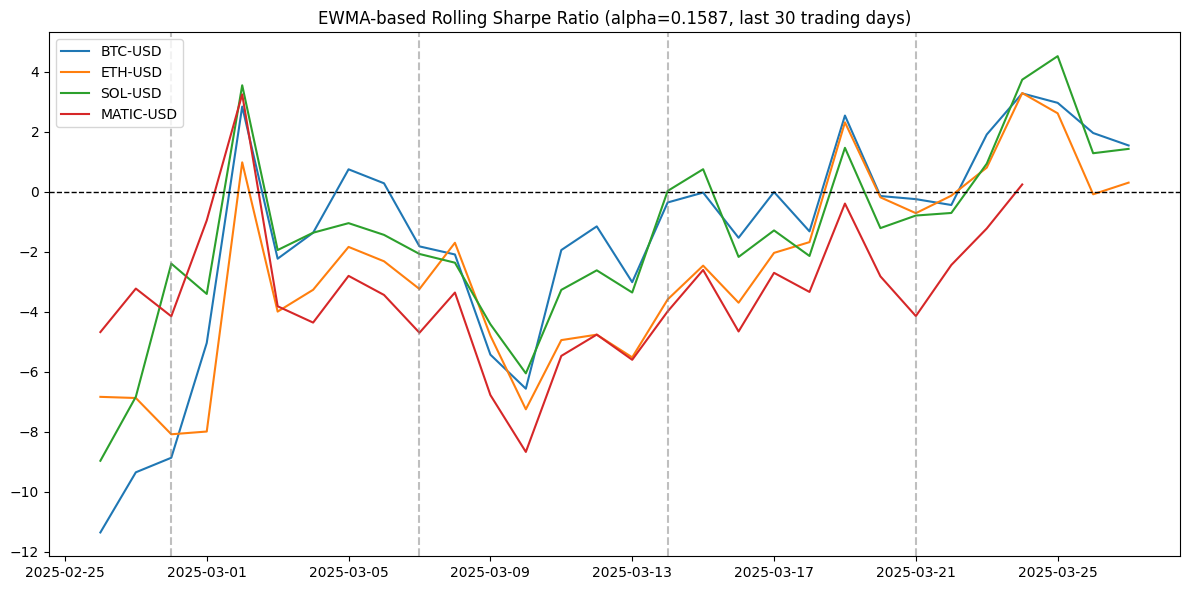

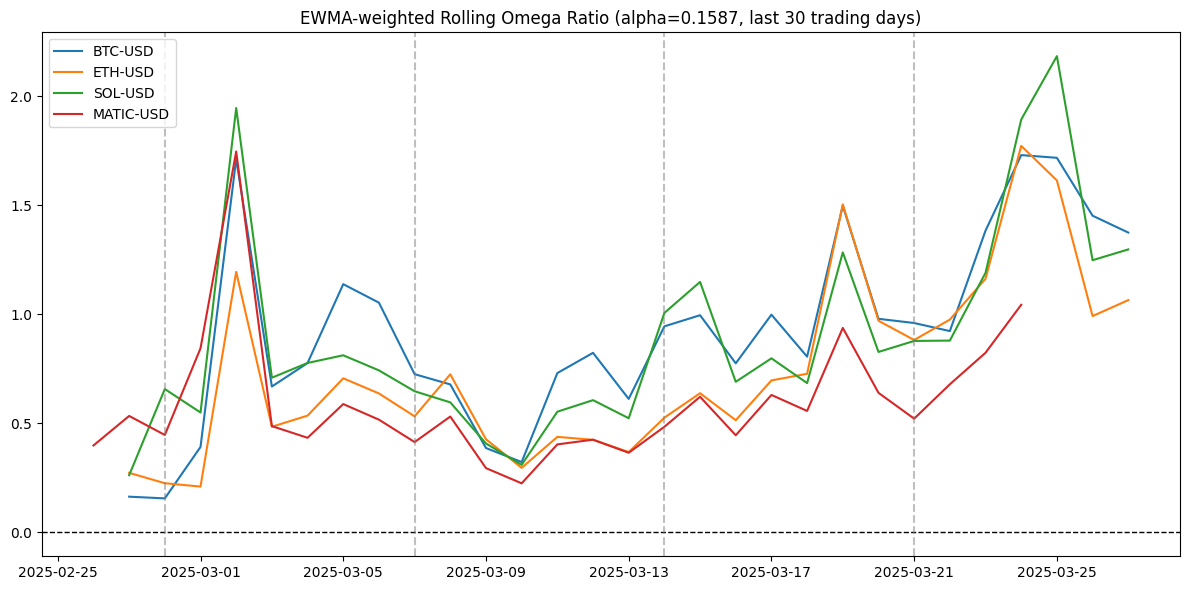


Latest EWMA-based Metrics (each ticker computed individually):
             Sharpe     Omega
BTC-USD    1.542643  1.374274
ETH-USD    0.303467  1.064608
SOL-USD    1.428775  1.296988
MATIC-USD  0.242534  1.043272

Normalization and Combined Weights:
             Sharpe     Omega  CombinedWeight
BTC-USD    0.510391  0.546160        0.508265
ETH-USD    0.023921  0.035204        0.037274
SOL-USD    0.465689  0.418637        0.443086
MATIC-USD  0.000000  0.000000        0.011375

Final Weights & Allocation:
             Sharpe     Omega  CombinedWeight    Allocation  Fraction  \
BTC-USD    1.542643  1.374274        0.508265  64549.648149  0.000185   
SOL-USD    1.428775  1.296988        0.443086  56271.929221  0.101712   
ETH-USD    0.303467  1.064608        0.037274   4733.797630  0.000597   
MATIC-USD  0.242534  1.043272        0.011375   1444.625000  1.618867   

                   Cost  
BTC-USD    64549.648149  
SOL-USD    56271.929221  
ETH-USD     4733.797630  
MATIC-USD   1444.625

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from datetime import datetime, timedelta

def get_fx_rate(ticker):
    """Fetch the latest closing rate for the given ticker using yfinance."""
    data = yf.Ticker(ticker).history(period="1d")
    return data["Close"].iloc[-1]

def omega_ratio_ewma(returns_series, threshold=0.0, alpha=0.1587):
    """
    Computes an EWMA-weighted Omega ratio for a series of returns.
    """
    n = len(returns_series)
    weights = np.array([(1 - alpha)**(n - i - 1) for i in range(n)])
    weights /= weights.sum()

    sorted_idx = np.argsort(returns_series)
    sorted_returns = returns_series.iloc[sorted_idx].values
    sorted_weights = weights[sorted_idx]

    above = sorted_returns > threshold
    numerator = np.sum(sorted_weights[above] * (sorted_returns[above] - threshold))

    below = sorted_returns < threshold
    denominator = np.sum(sorted_weights[below] * (threshold - sorted_returns[below]))

    return numerator / denominator if denominator != 0 else np.inf

def get_last_friday(reference_date=None):
    """
    Returns the most recent Friday (or the last available weekday) relative to the given reference_date.
    """
    if reference_date is None:
        reference_date = datetime.today()
    offset = (reference_date.weekday() - 4) % 7
    return reference_date - timedelta(days=offset)

def main(tickers, total_capital=416784, window=30, price_date=None):
    """
    For crypto tickers:
      - tickers: List of crypto ticker symbols (e.g., "BTC-USD", "ETH-USD", etc.).
      - total_capital: Total capital in COP.
      - window: Rolling window size in days.
      - price_date: (Optional) Date for the price to use. Defaults to the last Friday.

    The code downloads crypto price data, selects the effective close on the desired date,
    fetches the USD→COP conversion rate, converts prices to COP, computes EWMA-based metrics,
    and determines fractional allocation.
    """
    # ------------------------------------------------------------------------
    # 1) Download crypto data (6 months of daily Close).
    # ------------------------------------------------------------------------
    df = yf.download(tickers, period="6mo", interval="1d", progress=False)
    if "Close" not in df.columns:
        print("No 'Close' data found from yfinance. Exiting.")
        return
    all_closes = df["Close"]
    all_closes.sort_index(inplace=True)

    # ------------------------------------------------------------------------
    # 2) Determine the effective price_date.
    #     If not provided, default to the most recent Friday.
    # ------------------------------------------------------------------------
    if price_date is None:
        price_date = get_last_friday()
    else:
        price_date = pd.to_datetime(price_date)

    # Even though crypto trades continuously, we pick the last available day <= price_date.
    available_dates = all_closes.index[all_closes.index <= price_date]
    if len(available_dates) == 0:
        print(f"No available price data on or before {price_date.date()}. Exiting.")
        return
    effective_date = available_dates[-1]
    print(f"Using crypto closing prices from {effective_date.date()} for allocation calculations.")

    # ------------------------------------------------------------------------
    # 3) Fetch the USD to COP conversion rate.
    # ------------------------------------------------------------------------
    try:
        usdcop_rate = get_fx_rate("USDCOP=X")
    except Exception as e:
        print("Error fetching USD to COP conversion rate:", e)
        return

    # ------------------------------------------------------------------------
    # 4) Compute crypto prices in COP.
    #    For crypto tickers (ending with "-USD"), convert the USD price to COP.
    # ------------------------------------------------------------------------
    computed_prices = {}
    for ticker in tickers:
        try:
            raw_price = all_closes.loc[effective_date, ticker]
        except KeyError:
            print(f"Price for {ticker} not found on {effective_date.date()}, skipping.")
            continue
        # If ticker ends with "-USD", multiply by the USD→COP conversion rate.
        if ticker.endswith("-USD"):
            computed_prices[ticker] = raw_price * usdcop_rate
        else:
            computed_prices[ticker] = raw_price  # Otherwise, assume already in COP.

    print("\nComputed Crypto Prices (in COP):")
    for t, price in computed_prices.items():
        print(f"{t}: {price:,.2f}")

    # ------------------------------------------------------------------------
    # 5) Compute EWMA-based rolling Sharpe and Omega ratios.
    # ------------------------------------------------------------------------
    rolled_sharpe_dict = {}
    final_sharpe_dict = {}
    rolled_omega_dict = {}
    final_omega_dict = {}

    for ticker in tickers:
        series = all_closes[ticker].dropna()
        if len(series) < window:
            continue
        # Use the last 59 rows to ensure enough data for the rolling window.
        series = series.tail(59)

        # ----- Sharpe Ratio Calculation -----
        log_returns = np.log(series / series.shift(1)).dropna()
        if log_returns.empty:
            continue

        ewma_mean = log_returns.ewm(alpha=0.1587, adjust=False).mean()
        ewma_std = log_returns.ewm(alpha=0.1587, adjust=False).std()
        ann_factor = 252
        ewma_sharpe = (ewma_mean / ewma_std) * np.sqrt(ann_factor)
        ewma_sharpe.replace([np.inf, -np.inf], np.nan, inplace=True)
        ewma_sharpe.dropna(inplace=True)
        if ewma_sharpe.empty:
            continue

        rolled_sharpe_dict[ticker] = ewma_sharpe
        final_sharpe_dict[ticker] = ewma_sharpe.iloc[-1]

        # ----- Omega Ratio Calculation -----
        # ----- Omega Ratio Calculation -----
        log_returns = np.log(series / series.shift(1)).dropna()
        ewma_omega = log_returns.rolling(window=window).apply(
        lambda x: omega_ratio_ewma(pd.Series(x), threshold=0.0, alpha=0.1587),
        raw=False
        )
        if ewma_omega.empty:
            continue
        rolled_omega_dict[ticker] = ewma_omega
        final_omega_dict[ticker] = ewma_omega.iloc[-1]

    if not rolled_sharpe_dict or not rolled_omega_dict:
        print("No valid EWMA-based metrics for any ticker. Exiting.")
        return

    # ------------------------------------------------------------------------
    # 6) Plot EWMA-based rolling Sharpe for the LAST 30 TRADING DAYS.
    # ------------------------------------------------------------------------
    sharpe_df = pd.DataFrame(rolled_sharpe_dict).sort_index()
    plot_sharpe_df = sharpe_df.tail(30)

    fig, ax = plt.subplots(figsize=(12, 6))
    for ticker in plot_sharpe_df.columns:
        ax.plot(plot_sharpe_df.index, plot_sharpe_df[ticker], label=ticker)
    ax.set_title("EWMA-based Rolling Sharpe Ratio (alpha=0.1587, last 30 trading days)")
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    for dateval in plot_sharpe_df.index:
        if dateval.weekday() == 4:  # Mark Fridays
            ax.axvline(dateval, color='gray', linestyle='--', alpha=0.5)
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------------
    # 7) Plot EWMA-based rolling Omega Ratio for the LAST 30 TRADING DAYS.
    # ------------------------------------------------------------------------
    omega_df = pd.DataFrame(rolled_omega_dict).sort_index()
    plot_omega_df = omega_df.tail(30)

    fig, ax = plt.subplots(figsize=(12, 6))
    for ticker in plot_omega_df.columns:
        ax.plot(plot_omega_df.index, plot_omega_df[ticker], label=ticker)
    ax.set_title("EWMA-weighted Rolling Omega Ratio (alpha=0.1587, last 30 trading days)")
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    for dateval in plot_omega_df.index:
        if dateval.weekday() == 4:
            ax.axvline(dateval, color='gray', linestyle='--', alpha=0.5)
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------------
    # 8) Print final Sharpe and Omega ratios for each ticker.
    # ------------------------------------------------------------------------
    final_df = pd.DataFrame({
        "Sharpe": final_sharpe_dict,
        "Omega": final_omega_dict
    })
    final_df.dropna(inplace=True)
    print("\nLatest EWMA-based Metrics (each ticker computed individually):")
    print(final_df)

    # ------------------------------------------------------------------------
    # 9) Combine weights.
    # ------------------------------------------------------------------------
    # Compute z-scores for Sharpe and Omega ratios
    sharpe_z = (final_df["Sharpe"] - final_df["Sharpe"].mean()) / final_df["Sharpe"].std()
    omega_z  = (final_df["Omega"] - final_df["Omega"].mean()) / final_df["Omega"].std()

    # Shift z-scores to make them non-negative (if needed)
    sharpe_shift = sharpe_z - sharpe_z.min()
    omega_shift  = omega_z - omega_z.min()

    # Normalize the shifted scores to sum to one
    sharpe_norm = sharpe_shift / sharpe_shift.sum()
    omega_norm  = omega_shift / omega_shift.sum()

    naive_weight = 1.0 / len(final_df.index)
    w_sharpe = 0.6827
    w_omega = 0.2718
    w_naive = 0.0455

    combined_raw = (w_sharpe * sharpe_norm + w_omega * omega_norm + w_naive * naive_weight)
    combined_normalized = combined_raw / combined_raw.sum()
    final_df["CombinedWeight"] = combined_normalized


    print("\nNormalization and Combined Weights:")
    print(pd.DataFrame({
        "Sharpe": sharpe_norm,
        "Omega": omega_norm,
        "CombinedWeight": combined_normalized
    }))

    # ------------------------------------------------------------------------
    # 10) Calculate allocation of total_capital, fraction of crypto (shares), and cost.
    #     For crypto, we allow fractional purchases so we do not floor the division.
    # ------------------------------------------------------------------------
    allocation_list = []
    fraction_list = []
    cost_list = []

    for ticker in final_df.index:
        w = final_df.loc[ticker, "CombinedWeight"]
        allocation = w * total_capital
        price_per_unit = computed_prices.get(ticker, np.nan)
        if not np.isnan(price_per_unit) and price_per_unit > 0:
            # Fractional buy: do not floor division.
            fraction = allocation / price_per_unit
            cost = fraction * price_per_unit
        else:
            fraction = 0
            cost = 0
        allocation_list.append(allocation)
        fraction_list.append(fraction)
        cost_list.append(cost)

    final_df["Allocation"] = allocation_list
    final_df["Fraction"] = fraction_list
    final_df["Cost"] = cost_list

    final_df.sort_values(by="CombinedWeight", ascending=False, inplace=True)

    total_cost = final_df["Cost"].sum()
    leftover = total_capital - total_cost

    print("\nFinal Weights & Allocation:")
    print(final_df)
    print(f"\nTotal capital = {total_capital:,.2f} COP")
    print(f"Total cost    = {total_cost:,.2f} COP")
    print(f"Leftover cash = {leftover:,.2f} COP")
    print("------------------------------------")

# =================== EXAMPLE USAGE ===================
if __name__ == "__main__":
    crypto_tickers = ["BTC-USD", "ETH-USD", "SOL-USD", "MATIC-USD"]
    # Instead of providing a manual price dictionary, prices are computed live.
    # total_capital is defined in COP.
    # You can also specify a price_date (e.g., "2025-03-07") to override the default last Friday.
    main(
        tickers=crypto_tickers,
        total_capital=127000,  # example capital in COP
        window=30,
        price_date="2025-03-14"  # Uncomment to specify a manual date.
    )


FICs

Using data up to 2025-03-27 for calculations.


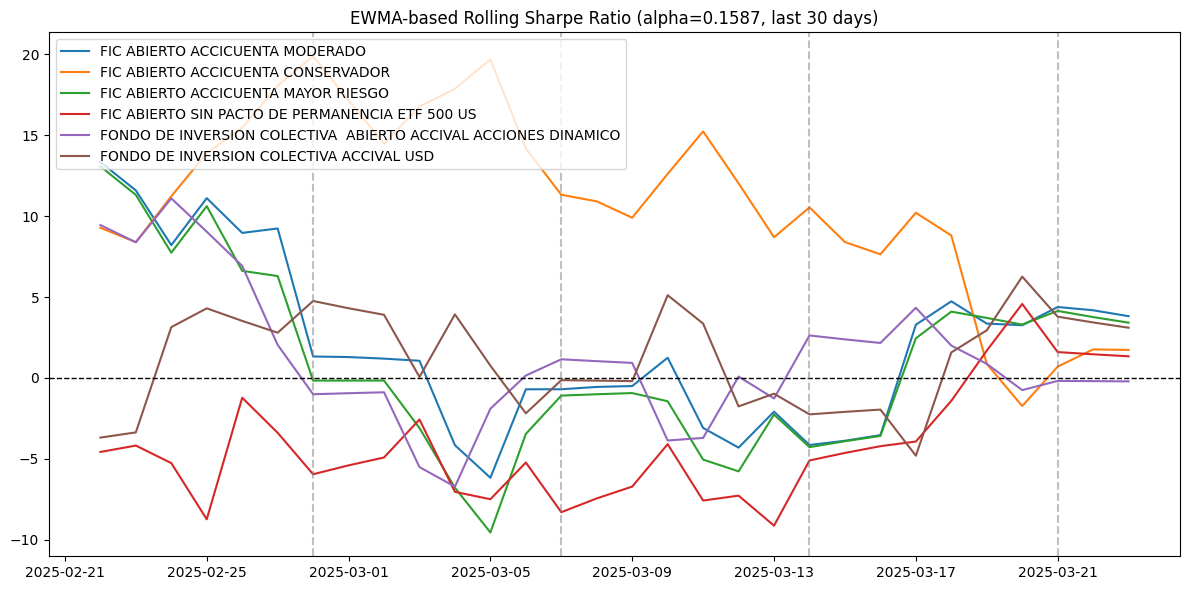

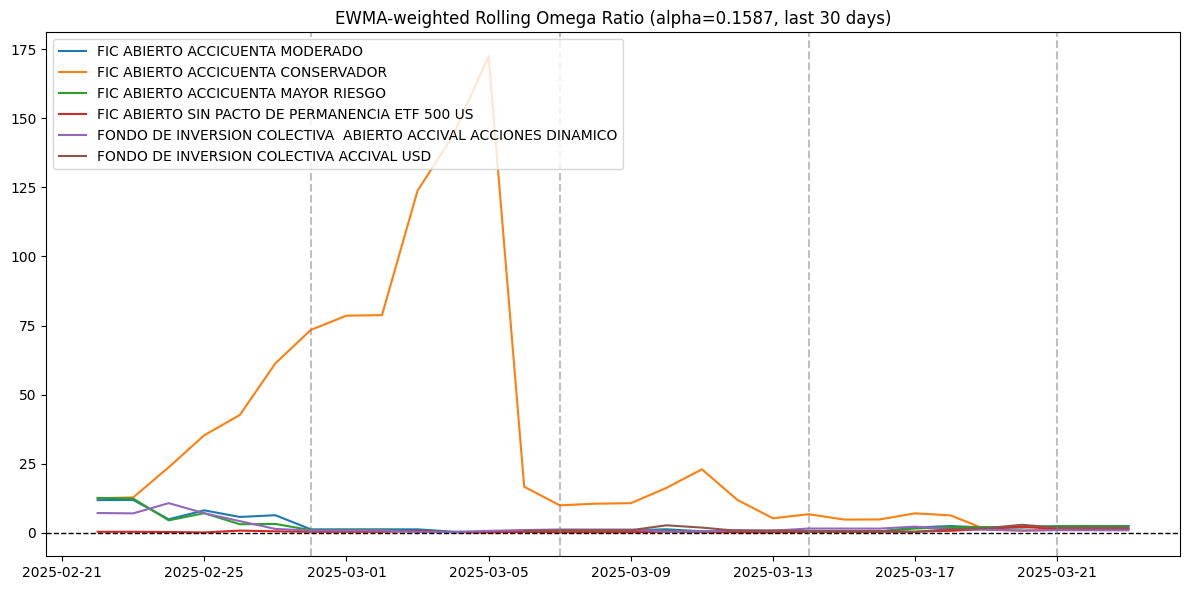


Final Weights & Allocation:
                                                      Sharpe     Omega  \
FIC ABIERTO ACCICUENTA MODERADO                     3.818003  2.461561   
FIC ABIERTO ACCICUENTA MAYOR RIESGO                 3.416874  2.329102   
FONDO DE INVERSION COLECTIVA ACCIVAL USD            3.104197  1.864120   
FIC ABIERTO ACCICUENTA CONSERVADOR                  1.728858  1.346606   
FIC ABIERTO SIN PACTO DE PERMANENCIA ETF 500 US     1.336581  1.310828   
FONDO DE INVERSION COLECTIVA  ABIERTO ACCIVAL A... -0.212524  0.936628   

                                                    CombinedWeight  \
FIC ABIERTO ACCICUENTA MODERADO                           0.287320   
FIC ABIERTO ACCICUENTA MAYOR RIESGO                       0.260614   
FONDO DE INVERSION COLECTIVA ACCIVAL USD                  0.218557   
FIC ABIERTO ACCICUENTA CONSERVADOR                        0.123269   
FIC ABIERTO SIN PACTO DE PERMANENCIA ETF 500 US           0.102657   
FONDO DE INVERSION COLECTIVA  AB

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# -------------------- Data Fetching Function --------------------
def fetch_investment_funds_data(fecha_inicio, fecha_fin):
    """
    Fetch data from the Colombian open data portal for Acciones y Valores S.A. funds
    within the specified date range.
    """
    url = "https://www.datos.gov.co/resource/qhpu-8ixx.json"
    query = f"""
          SELECT
            fecha_corte,
            nombre_entidad,
            codigo_negocio,
            nombre_patrimonio,
            valor_unidad_operaciones
        WHERE 1=1
          AND (fecha_corte >= '{fecha_inicio}T00:00:00' AND fecha_corte <= '{fecha_fin}T23:59:59')
          --AND (nombre_entidad = 'Acciones Y Valores S.A.  Comisionistas De Bolsa')
          AND codigo_negocio IN ('115128','115124','115127','119695','58735','123763')
    """
    params = {"$query": query}
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data)
        return df
    else:
        print(f"Error en la solicitud: {response.status_code}")
        return pd.DataFrame()

# -------------------- Helper: Last Friday --------------------
def get_last_friday(reference_date=None):
    """
    Returns the most recent Friday (or the last weekday) relative to reference_date.
    """
    if reference_date is None:
        reference_date = datetime.today()
    offset = (reference_date.weekday() - 4) % 7
    return reference_date - timedelta(days=offset)

# -------------------- Omega Ratio Function --------------------
def omega_ratio_ewma(returns_series, threshold=0.0, alpha=0.1587):
    """
    Computes an EWMA-weighted Omega ratio for a series of returns.
    """
    n = len(returns_series)
    weights = np.array([(1 - alpha)**(n - i - 1) for i in range(n)])
    weights /= weights.sum()

    sorted_idx = np.argsort(returns_series)
    sorted_returns = returns_series.iloc[sorted_idx].values
    sorted_weights = weights[sorted_idx]

    above = sorted_returns > threshold
    numerator = np.sum(sorted_weights[above] * (sorted_returns[above] - threshold))

    below = sorted_returns < threshold
    denominator = np.sum(sorted_weights[below] * (threshold - sorted_returns[below]))

    return numerator / denominator if denominator != 0 else np.inf

# -------------------- Main Analysis Function --------------------
def main_mutual_funds(df, initial_investment=1000000, window=30, price_date=None):
    """
    Computes EWMA-based rolling Sharpe and Omega ratios for each mutual fund,
    up to a specified 'price_date' (or last Friday if not provided).
    Combines these metrics into allocation percentages, and plots the rolling metrics.

    Parameters:
      df: DataFrame with columns ["fecha_corte", "nombre_patrimonio", "log_return"].
      initial_investment: The total investment amount; allocations are % of this.
      window: Rolling window (in days) used to compute the metrics.
      price_date: (Optional) Date string (e.g. "2025-03-21") for the cutoff date.
                  If None, uses the most recent Friday prior to today's date.
    """

    # 1) Determine the effective price_date
    if price_date is None:
        price_date = get_last_friday()
    else:
        price_date = pd.to_datetime(price_date)

    # Filter df to only include data on or before price_date
    df = df[df['fecha_corte'] <= price_date].copy()
    if df.empty:
        print(f"No data available on or before {price_date.date()}. Exiting.")
        return

    print(f"Using data up to {price_date.date()} for calculations.")

    # 2) Ensure the DataFrame is sorted by date
    df.sort_values('fecha_corte', inplace=True)

    # 3) Identify unique funds
    funds = df['nombre_patrimonio'].unique()

    # Dictionaries to store rolling metrics and final metrics per fund
    rolled_sharpe_dict = {}
    final_sharpe_dict = {}
    rolled_omega_dict = {}
    final_omega_dict = {}

    # Annualization factor (assuming daily data)
    ann_factor = 252

    # 4) Process each fund individually
    for fund in funds:
        df_fund = df[df['nombre_patrimonio'] == fund].copy()

        # Set the date column as the index for proper time-series
        df_fund.sort_values('fecha_corte', inplace=True)
        df_fund.set_index('fecha_corte', inplace=True)

        # Drop NaNs in log_return
        log_returns = df_fund['log_return'].dropna()
        if len(log_returns) < window:
            # Skip if there is not enough data for the rolling window
            continue

        # Optionally, take a bit more data for EWMA stability
        log_returns = log_returns.tail(window + 29)

        # ----- Sharpe Ratio Calculation (EWMA) -----
        ewma_mean = log_returns.ewm(alpha=0.1587, adjust=False).mean()
        ewma_std = log_returns.ewm(alpha=0.1587, adjust=False).std()
        ewma_sharpe = (ewma_mean / ewma_std) * np.sqrt(ann_factor)
        ewma_sharpe.replace([np.inf, -np.inf], np.nan, inplace=True)
        ewma_sharpe.dropna(inplace=True)
        if ewma_sharpe.empty:
            continue

        rolled_sharpe_dict[fund] = ewma_sharpe
        final_sharpe_dict[fund] = ewma_sharpe.iloc[-1]

        # ----- Omega Ratio Calculation (EWMA) -----
        ewma_omega = log_returns.rolling(window=window).apply(
            lambda x: omega_ratio_ewma(pd.Series(x), threshold=0.0, alpha=0.1587),
            raw=False
        )
        ewma_omega.dropna(inplace=True)
        if ewma_omega.empty:
            continue
        rolled_omega_dict[fund] = ewma_omega
        final_omega_dict[fund] = ewma_omega.iloc[-1]

    # If no valid metrics, exit
    if not rolled_sharpe_dict or not rolled_omega_dict:
        print("No valid EWMA-based metrics for any fund. Exiting.")
        return

    # -----------------------------------------------------------------
    # 5) Create Sharpe/Omega DataFrames and unify their date indexes
    #    so the Friday markers align across both plots
    # -----------------------------------------------------------------
    sharpe_df = pd.DataFrame(rolled_sharpe_dict).sort_index()
    omega_df  = pd.DataFrame(rolled_omega_dict).sort_index()

    # Build a common index (union of all dates in Sharpe and Omega)
    common_index = sharpe_df.index.union(omega_df.index)
    common_index = common_index.sort_values()

    # Reindex both DataFrames to the common index
    sharpe_df = sharpe_df.reindex(common_index)
    omega_df  = omega_df.reindex(common_index)

    # Take the last 30 rows from each
    plot_sharpe_df = sharpe_df.tail(30)
    plot_omega_df  = omega_df.tail(30)

    # -------------------- Plot Sharpe --------------------
    fig, ax = plt.subplots(figsize=(12, 6))
    for fund in plot_sharpe_df.columns:
        ax.plot(plot_sharpe_df.index, plot_sharpe_df[fund], label=fund)
    ax.set_title("EWMA-based Rolling Sharpe Ratio (alpha=0.1587, last 30 days)")
    ax.axhline(0, color='black', linestyle='--', linewidth=1)

    # Mark Fridays on the x-axis
    for dateval in plot_sharpe_df.index:
        if dateval.weekday() == 4:  # Friday
            ax.axvline(dateval, color='gray', linestyle='--', alpha=0.5)

    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

    # -------------------- Plot Omega --------------------
    fig, ax = plt.subplots(figsize=(12, 6))
    for fund in plot_omega_df.columns:
        ax.plot(plot_omega_df.index, plot_omega_df[fund], label=fund)
    ax.set_title("EWMA-weighted Rolling Omega Ratio (alpha=0.1587, last 30 days)")
    ax.axhline(0, color='black', linestyle='--', linewidth=1)

    # Mark Fridays on the x-axis
    for dateval in plot_omega_df.index:
        if dateval.weekday() == 4:  # Friday
            ax.axvline(dateval, color='gray', linestyle='--', alpha=0.5)

    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

    # -------------------- Final Metrics and Combined Weights --------------------
    final_df = pd.DataFrame({
        "Sharpe": final_sharpe_dict,
        "Omega": final_omega_dict
    })
    final_df.dropna(inplace=True)

    #print("\nLatest EWMA-based Metrics (each fund computed individually):")
    #print(final_df)

    # Compute z-scores for Sharpe and Omega
    sharpe_z = (final_df["Sharpe"] - final_df["Sharpe"].mean()) / final_df["Sharpe"].std()
    omega_z  = (final_df["Omega"] - final_df["Omega"].mean()) / final_df["Omega"].std()

    # Shift z-scores to make them non-negative (if needed)
    sharpe_shift = sharpe_z - sharpe_z.min()
    omega_shift  = omega_z - omega_z.min()

    # Normalize the shifted scores to sum to one
    sharpe_norm = sharpe_shift / sharpe_shift.sum()
    omega_norm  = omega_shift / omega_shift.sum()

    # Weights for combining the metrics
    naive_weight = 1.0 / len(final_df.index)
    w_sharpe = 0.6827
    w_omega  = 0.2718
    w_naive  = 0.0455

    combined_raw = (w_sharpe * sharpe_norm + w_omega * omega_norm + w_naive * naive_weight)
    combined_normalized = combined_raw / combined_raw.sum()
    final_df["CombinedWeight"] = combined_normalized
    '''
    #print("\nNormalization and Combined Weights:")
    print(pd.DataFrame({
        "Sharpe": sharpe_norm,
        "Omega": omega_norm,
        "CombinedWeight": combined_normalized
    }))
    '''
    # -------------------- Allocation Calculation --------------------
    #final_df["AllocationPercentage"] = combined_normalized
    final_df["AllocatedAmount"] = combined_normalized * initial_investment

    final_df.sort_values(by="CombinedWeight", ascending=False, inplace=True)

    total_alloc = final_df["AllocatedAmount"].sum()
    leftover = initial_investment - total_alloc

    print("\nFinal Weights & Allocation:")
    print(final_df)
    print(f"\nInitial Investment = {initial_investment:,.2f}")
    print(f"Total Allocated   = {total_alloc:,.2f}")
    print(f"Leftover Cash     = {leftover:,.2f}")
    print("------------------------------------")

# -------------------- Main Execution --------------------
if __name__ == "__main__":
    # 1) Define date range for the last 6 months
    today = datetime.today()
    fecha_fin = today.strftime('%Y-%m-%d')
    start_date = today - timedelta(days=30*6)  # 6 months
    fecha_inicio = start_date.strftime('%Y-%m-%d')

    # 2) Fetch the mutual fund data
    df = fetch_investment_funds_data(fecha_inicio, fecha_fin)

    if df.empty:
        print("No data fetched. Exiting.")
    else:
        # 3) Preprocess the data
        df['fecha_corte'] = pd.to_datetime(df['fecha_corte'])
        df.sort_values('fecha_corte', inplace=True)
        df['valor_unidad_operaciones'] = pd.to_numeric(df['valor_unidad_operaciones'], errors='coerce')

        # Compute log returns for each fund
        fondos = df['nombre_patrimonio'].unique()
        df_list = []
        for fondo in fondos:
            df_fondo = df[df['nombre_patrimonio'] == fondo].copy()
            df_fondo.sort_values('fecha_corte', inplace=True)
            df_fondo['log_return'] = np.log(
                df_fondo['valor_unidad_operaciones'] /
                df_fondo['valor_unidad_operaciones'].shift(1)
            )
            df_list.append(df_fondo)
        df_preprocessed = pd.concat(df_list)

        # 4) Run the main allocation function
        #    You can pass a specific date (e.g. "2025-03-21") or leave it None to use last Friday.
        main_mutual_funds(
            df_preprocessed,
            initial_investment=1000000,
            window=30,
            price_date="2025-03-27"  # e.g. "2025-03-21" if you want a specific date
        )
